In [1]:
## Create combined DE csv from both datasets
import pandas as pd

# Adjusted file paths
path_df1 = "~/Desktop/Capstone/Notebook recent/GSE180286_DE_oncogenes.csv"
path_df2 = "~/Desktop/Capstone/Notebook recent/GSE161529_DE_oncogenes.csv"

# Load the datasets and tag with dataset source
df1 = pd.read_csv(path_df1)
df1["Dataset"] = "GSE180286"

df2 = pd.read_csv(path_df2)
df2["Dataset"] = "GSE161529"

# Standardize gene column if needed
df1["gene"] = df1["gene"].str.upper()
df2["gene"] = df2["gene"].str.upper()

# Combine both
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save combined file
combined_df.to_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv", index=False)

print("✅ combined_de_genes.csv created successfully.")

✅ combined_de_genes.csv created successfully.


In [132]:
import pandas as pd

# 🔹 Step 1: Load the annotated differential expression results
df = pd.read_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv")
# 🔹 Step 5: Sort by dataset and log2 fold-change
#df = df.sort_values(by=["Dataset", "log2FC"], ascending=[True, False])
print(df.head(10))
print(df.shape)



     gene  p_value   log2_fc  mean_diff    Dataset
0    CDK4      0.0  2.428112   0.105542  GSE180286
1  CDKN1A      0.0  3.365022   0.134859  GSE180286
2   ERBB2      0.0  4.833174   0.267847  GSE180286
3   CCND1      0.0  4.525871   0.483840  GSE180286
4  CDKN2A      0.0  3.926487   0.074630  GSE180286
5   FOXO3      0.0  2.274698   0.093662  GSE180286
6     BAX      0.0  1.529315   0.185898  GSE180286
7    KRAS      0.0  1.327114   0.171800  GSE180286
8   FGFR1      0.0  3.608174   0.090912  GSE180286
9    MDM2      0.0  1.729504   0.087250  GSE180286
(78, 5)


In [3]:
## Step 1: Load DGIdb interaction data and extract druggable genes

import pandas as pd
import os

# Load DGIdb interactions.tsv (adjust path as needed)
dgidb_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/interactions.tsv")
dgidb_df = pd.read_csv(dgidb_path, sep="\t")

# Filter druggable genes: approved or anti-neoplastic
dgidb_filtered = dgidb_df[
    (dgidb_df["approved"] == True) | (dgidb_df["anti_neoplastic"] == True)
]

# Unique druggable gene symbols (uppercased for consistency)
druggable_genes = dgidb_filtered["gene_name"].dropna().str.upper().unique()
print(f"Number of druggable genes from DGIdb: {len(druggable_genes)}")


Number of druggable genes from DGIdb: 3579


In [4]:
## Step 2: Query Open Targets API for breast cancer target association scores
import requests

url = "https://api.platform.opentargets.org/api/v4/graphql"
query = """
query BreastCancerTargets($efoId: String!, $size: Int!) {
  disease(efoId: $efoId) {
    associatedTargets(page: { index: 0, size: $size }) {
      rows {
        target {
          approvedSymbol
        }
        score
      }
    }
  }
}
"""
variables = {
    "efoId": "EFO_0000305",  # Breast cancer EFO ID
    "size": 500
}

response = requests.post(url, json={"query": query, "variables": variables})
data = response.json()

if "errors" in data:
    raise Exception(f"Open Targets API error: {data['errors']}")

rows = data["data"]["disease"]["associatedTargets"]["rows"]

open_targets_df = pd.DataFrame([
    {
        "Gene": row["target"]["approvedSymbol"].upper(),
        "OpenTargets_Score": row["score"]
    }
    for row in rows if row.get("score") is not None
])

# Filter strong breast cancer associations
open_targets_df = open_targets_df[open_targets_df["OpenTargets_Score"] >= 0.5]

print(f"Number of genes strongly associated with breast cancer (Open Targets): {open_targets_df.shape[0]}")


Number of genes strongly associated with breast cancer (Open Targets): 316


In [5]:
## Step 3: Merge DE genes with DGIdb and Open Targets info
# Ensure gene symbols uppercase in DE dataframe for consistency
df["Gene"] = df["gene"].str.upper()

# Add DGIdb Status
df["DGIdb Status"] = df["Gene"].apply(lambda x: "Targeted" if x in druggable_genes else "Not Targeted")

# Merge with Open Targets scores (left join to keep all DE genes)
df = df.merge(open_targets_df, how="left", left_on="Gene", right_on="Gene")

# Add breast cancer support flags
df["BreastCancer_Supported"] = df["OpenTargets_Score"].notna()
df["Strong_BreastCancer_Support"] = df["OpenTargets_Score"].fillna(0) >= 0.5



In [6]:
## Step 4: Add FDA approval info from DGIdb data 
# To get FDA approval status, use the dgidb_filtered dataframe:
# Extract gene-wise FDA approval flag

# Prepare dictionary mapping gene -> FDA approved (True/False)
fda_dict = dgidb_filtered.groupby("gene_name")["approved"].max().to_dict()

# Map it onto df
df["FDA_Approved_Drug"] = df["Gene"].map(fda_dict).fillna(False)
df["FDA_Approved_Drug"] = df["FDA_Approved_Drug"].map({True: "Yes", False: "No"})


In [7]:
## Step 5: Assign therapeutic categories specific to breast cancer

def assign_targeting_category(row):
    if row["Strong_BreastCancer_Support"]:
        if row["DGIdb Status"] == "Targeted":
            if row["FDA_Approved_Drug"] == "Yes":
                return "FDA-approved Breast Cancer Therapy"
            else:
                return "Emerging Breast Cancer Target"
        else:
            return "Lacks Breast Cancer Evidence"
    else:
        return "Lacks Breast Cancer Evidence"

df["Targeting Category"] = df.apply(assign_targeting_category, axis=1)


In [8]:
##Step 6: Save the annotated dataframe

output_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_30July.csv")
df.to_csv(output_path, index=False)
print(f"✅ Saved annotated therapeutic stratification to {output_path}")


✅ Saved annotated therapeutic stratification to /Users/adi/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_30July.csv


In [9]:
##Load and review the saved CSV contents, including summary statistics for therapeutic categories:
import pandas as pd

# Load the annotated therapeutic stratification CSV
csv_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_30July.csv"
df = pd.read_csv(csv_path)

# Show the first few rows
print("### Preview of data ###")
print(df.head())

# Summary of therapeutic categories
print("\n### Therapeutic Category counts ###")
print(df['Targeting Category'].value_counts())

# Summary statistics for log2FC by category
print("\n### Summary statistics of log2FC by Targeting Category ###")
print(df.groupby('Targeting Category')['log2_fc'].describe())

# Optional: List unique genes per category
for cat in df['Targeting Category'].unique():
    genes = df.loc[df['Targeting Category'] == cat, 'gene'].unique()
    print(f"\nCategory: {cat} — {len(genes)} unique genes")
    print(genes[:10])  # print first 10 genes



### Preview of data ###
     gene  p_value   log2_fc  mean_diff    Dataset    Gene DGIdb Status  \
0    CDK4      0.0  2.428112   0.105542  GSE180286    CDK4     Targeted   
1  CDKN1A      0.0  3.365022   0.134859  GSE180286  CDKN1A     Targeted   
2   ERBB2      0.0  4.833174   0.267847  GSE180286   ERBB2     Targeted   
3   CCND1      0.0  4.525871   0.483840  GSE180286   CCND1     Targeted   
4  CDKN2A      0.0  3.926487   0.074630  GSE180286  CDKN2A     Targeted   

   OpenTargets_Score  BreastCancer_Supported  Strong_BreastCancer_Support  \
0           0.693263                    True                         True   
1                NaN                   False                        False   
2           0.820020                    True                         True   
3           0.568711                    True                         True   
4           0.592468                    True                         True   

  FDA_Approved_Drug                  Targeting Category  
0   

In [10]:
# Assuming your dataframe is named df

# Drop duplicates based on 'gene' column, keeping the first occurrence
df_unique = df.drop_duplicates(subset='gene', keep='first').reset_index(drop=True)

# Check counts to confirm
print("Counts after deduplication by gene:")
print(df_unique['Targeting Category'].value_counts())
print(f"Total unique genes: {df_unique['gene'].nunique()}")

# Now df_unique is ready for downstream analysis
for category, group in df_unique.groupby('Targeting Category'):
    genes = group['gene'].tolist()
    print(f"\nCategory: {category} — {len(genes)} unique genes")
    print(genes)



Counts after deduplication by gene:
Targeting Category
FDA-approved Breast Cancer Therapy    31
Lacks Breast Cancer Evidence           8
Emerging Breast Cancer Target          1
Name: count, dtype: int64
Total unique genes: 40

Category: Emerging Breast Cancer Target — 1 unique genes
['CASP8']

Category: FDA-approved Breast Cancer Therapy — 31 unique genes
['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']

Category: Lacks Breast Cancer Evidence — 8 unique genes
['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']


In [11]:
import pandas as pd

# Example: load your deduplicated dataframe if not already in memory
# df_unique = pd.read_csv("path_to_your_deduplicated_file.csv")

# Step 1: Dynamically find FDA-approved breast cancer genes
fda_bc_specific_genes = df_unique[
    (df_unique["FDA_Approved_Drug"] == "Yes") &
    (df_unique["OpenTargets_Score"].fillna(0) >= 0.5)
]["Gene"].unique().tolist()

print(f"✅ Dynamically found {len(fda_bc_specific_genes)} FDA-approved genes for breast cancer.")
print(fda_bc_specific_genes)

# Step 2: Filter FDA-approved Breast Cancer Therapy genes and assign subcategories
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()

df_fda['FDA_Subcategory'] = df_fda['Gene'].apply(
    lambda g: 'FDA-approved for Breast Cancer' if g in fda_bc_specific_genes else 'FDA-approved for Other Cancer/General'
)

print("\n✅ FDA Subcategory counts:")
print(df_fda['FDA_Subcategory'].value_counts())

# Step 3: Combine back with other targeting categories
df_other = df_unique[df_unique['Targeting Category'] != 'FDA-approved Breast Cancer Therapy'].copy()

df_final = pd.concat([df_fda, df_other], ignore_index=True)

# Optional: save the updated dataframe
output_path = "~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_dynamic.csv"
df_final.to_csv(output_path, index=False)
print(f"\n✅ Saved file with FDA subcategories: {output_path}")



✅ Dynamically found 31 FDA-approved genes for breast cancer.
['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']

✅ FDA Subcategory counts:
FDA_Subcategory
FDA-approved for Breast Cancer    31
Name: count, dtype: int64

✅ Saved file with FDA subcategories: ~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_dynamic.csv


In [12]:
import pandas as pd
import os

# Assuming df_unique is your deduplicated dataframe after previous steps
# df_unique columns: ['gene', 'Targeting Category', 'Pathway Category', ... other cols]

# 1. Dynamically extract gene lists by category
fda_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "FDA-approved Breast Cancer Therapy", "gene"].unique().tolist()
emerging_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "Emerging Breast Cancer Target", "gene"].unique().tolist()
lacks_bc_genes = df_unique.loc[df_unique["Targeting Category"] == "Lacks Breast Cancer Evidence", "gene"].unique().tolist()

print(f"✅ FDA-approved Breast Cancer Therapy genes ({len(fda_bc_genes)}): {fda_bc_genes}")
print(f"✅ Emerging Breast Cancer Target genes ({len(emerging_bc_genes)}): {emerging_bc_genes}")
print(f"✅ Lacks Breast Cancer Evidence genes ({len(lacks_bc_genes)}): {lacks_bc_genes}")

# 2. Create a new column FDA_Subcategory with subgroups (example below is simple)
def fda_subcategory(row):
    if row["gene"] in fda_bc_genes:
        return "FDA-approved for Breast Cancer"
    elif row["gene"] in emerging_bc_genes:
        return "Emerging Breast Cancer Target"
    elif row["gene"] in lacks_bc_genes:
        return "Lacks Breast Cancer Evidence"
    else:
        return "Other"

df_unique["Therapeutic Subcategory"] = df_unique.apply(fda_subcategory, axis=1)
df_unique.head(5)
# 3. If you have pathway info in df_unique or a master file, merge here (assuming pathway column exists)
# If separate master file:
# master_df = pd.read_csv("path_to_master_with_pathways.csv")
# df_unique = df_unique.merge(master_df[['gene', 'Pathway Category']], on='gene', how='left')

# 4. Add drug trial data
# Assuming you have a dataframe trial_df with columns: ['gene', 'Breast Cancer Trial'] (True/False)
# trial_df = pd.read_csv("path_to_trial_info.csv")
# df_unique = df_unique.merge(trial_df, on='gene', how='left')
# Fill missing trial info as False
# df_unique['Breast Cancer Trial'] = df_unique['Breast Cancer Trial'].fillna(False)

# 5. Save the final dataframe
# output_path = os.path.expanduser("~/Desktop/Cancer_project/ghost-cell-busters/final_therapeutic_subcategories_extended.csv")
# df_unique.to_csv(output_path, index=False)
# print(f"✅ Saved final annotated therapeutic subcategories with pathways and trials to {output_path}")


✅ FDA-approved Breast Cancer Therapy genes (31): ['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']
✅ Emerging Breast Cancer Target genes (1): ['CASP8']
✅ Lacks Breast Cancer Evidence genes (8): ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']


,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,Therapeutic Subcategory
0,CDK4,0.0,2.428112,0.105542,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
1,CDKN1A,0.0,3.365022,0.134859,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,Lacks Breast Cancer Evidence
2,ERBB2,0.0,4.833174,0.267847,GSE180286,ERBB2,Targeted,0.820020,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
3,CCND1,0.0,4.525871,0.483840,GSE180286,CCND1,Targeted,0.568711,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
4,CDKN2A,0.0,3.926487,0.074630,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer


In [13]:
df_unique.head(5)

,gene,p_value,log2_fc,mean_diff,Dataset,Gene,DGIdb Status,OpenTargets_Score,BreastCancer_Supported,Strong_BreastCancer_Support,FDA_Approved_Drug,Targeting Category,Therapeutic Subcategory
0,CDK4,0.0,2.428112,0.105542,GSE180286,CDK4,Targeted,0.693263,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
1,CDKN1A,0.0,3.365022,0.134859,GSE180286,CDKN1A,Targeted,NaN,False,False,Yes,Lacks Breast Cancer Evidence,Lacks Breast Cancer Evidence
2,ERBB2,0.0,4.833174,0.267847,GSE180286,ERBB2,Targeted,0.820020,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
3,CCND1,0.0,4.525871,0.483840,GSE180286,CCND1,Targeted,0.568711,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer
4,CDKN2A,0.0,3.926487,0.074630,GSE180286,CDKN2A,Targeted,0.592468,True,True,Yes,FDA-approved Breast Cancer Therapy,FDA-approved for Breast Cancer


In [14]:
 ## to infer Clinical Trial Status from your existing columns related to breast cancer relevance, such as the Open Targets breast cancer trial flags
# Assume your dataframe is called df (e.g., final therapeutic stratification df)
def clinical_trial_status(row):
    # Define trial status if strongly breast cancer supported or high OpenTargets score
    if pd.notna(row['OpenTargets_Score']) and row['OpenTargets_Score'] >= 0.5:
        return "In Breast Cancer Trial"
    elif row['Strong_BreastCancer_Support']:
        return "In Breast Cancer Trial"
    else:
        return "No Breast Cancer Trial"

df_unique['Clinical_Trial_Status'] = df_unique.apply(clinical_trial_status, axis=1)

# Check results
print(df_unique[['gene', 'Clinical_Trial_Status']].head(10))



     gene   Clinical_Trial_Status
0    CDK4  In Breast Cancer Trial
1  CDKN1A  No Breast Cancer Trial
2   ERBB2  In Breast Cancer Trial
3   CCND1  In Breast Cancer Trial
4  CDKN2A  In Breast Cancer Trial
5   FOXO3  In Breast Cancer Trial
6     BAX  No Breast Cancer Trial
7    KRAS  In Breast Cancer Trial
8   FGFR1  In Breast Cancer Trial
9    MDM2  In Breast Cancer Trial


In [15]:
output_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv"
df_unique.to_csv(output_path, index=False)
print(f"✅ Saved annotated file with clinical trial status to {output_path}")

✅ Saved annotated file with clinical trial status to ~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv


In [16]:
import pandas as pd

# Load the annotated file with clinical trial status
file_path = "~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv"
df = pd.read_csv(file_path)

# Quick check of the columns and sample data
print(df.columns)
print(df[['Gene', 'Targeting Category', 'Clinical_Trial_Status']].head(10))

# If needed, fill missing trial status (safe practice)
df['Clinical_Trial_Status'] = df['Clinical_Trial_Status'].fillna('No Breast Cancer Trial')

# Example: Summary counts by Clinical Trial Status and Targeting Category
summary = df.groupby(['Targeting Category', 'Clinical_Trial_Status']).size().reset_index(name='counts')
print(summary)

# # Save again if any modifications made
# df.to_csv(file_path, index=False)
# print(f"✅ Updated file saved at {file_path}")


Index(['gene', 'p_value', 'log2_fc', 'mean_diff', 'Dataset', 'Gene',
       'DGIdb Status', 'OpenTargets_Score', 'BreastCancer_Supported',
       'Strong_BreastCancer_Support', 'FDA_Approved_Drug',
       'Targeting Category', 'Therapeutic Subcategory',
       'Clinical_Trial_Status'],
      dtype='object')
     Gene                  Targeting Category   Clinical_Trial_Status
0    CDK4  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
1  CDKN1A        Lacks Breast Cancer Evidence  No Breast Cancer Trial
2   ERBB2  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
3   CCND1  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
4  CDKN2A  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
5   FOXO3  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
6     BAX        Lacks Breast Cancer Evidence  No Breast Cancer Trial
7    KRAS  FDA-approved Breast Cancer Therapy  In Breast Cancer Trial
8   FGFR1  FDA-approved Breast Cancer Therapy  In Breast Canc

In [17]:
## Sankey Plot Code: Therapeutic Categories → Clinical Trial Status → Genes
import plotly.graph_objects as go
import pandas as pd

# Load your annotated dataframe (replace with your actual path if needed)
df = pd.read_csv("~/Desktop/Cancer_project/ghost-cell-busters/oncogene_therapeutic_stratification_with_trial.csv")

# Deduplicate on gene to avoid repeats in plot
df_unique = df.drop_duplicates(subset=["gene", "Targeting Category", "Clinical_Trial_Status"]).copy()

# Define major nodes (categories and trial statuses)
categories = df_unique["Targeting Category"].unique().tolist()
trial_statuses = df_unique["Clinical_Trial_Status"].unique().tolist()
genes = df_unique["gene"].unique().tolist()

# Combine all nodes in order
label_list = categories + trial_statuses + genes

# Create a dict to map label to index
label_to_idx = {label: i for i, label in enumerate(label_list)}

# Prepare sankey links
source = []
target = []
value = []
colors = []

# Color palette (you can customize)
category_colors = {
    "FDA-approved Breast Cancer Therapy": "green",
    "Emerging Breast Cancer Target": "orange",
    "Lacks Breast Cancer Evidence": "red",
}
trial_colors = {
    "In Breast Cancer Trial": "blue",
    "No Breast Cancer Trial": "gray",
}

# 1) Links from Categories → Clinical Trial Status
for cat in categories:
    for trial in trial_statuses:
        count = df_unique[
            (df_unique["Targeting Category"] == cat) &
            (df_unique["Clinical_Trial_Status"] == trial)
        ].shape[0]
        if count > 0:
            source.append(label_to_idx[cat])
            target.append(label_to_idx[trial])
            value.append(count)
            colors.append(category_colors.get(cat, "lightgray"))

# 2) Links from Clinical Trial Status → Genes
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row["Clinical_Trial_Status"]])
    target.append(label_to_idx[row["gene"]])
    value.append(1)
    colors.append(trial_colors.get(row["Clinical_Trial_Status"], "lightgray"))

# Node colors: categories and trial statuses get colored, genes are light gray
node_colors = []
for label in label_list:
    if label in category_colors:
        node_colors.append(category_colors[label])
    elif label in trial_colors:
        node_colors.append(trial_colors[label])
    else:
        node_colors.append("lightgray")

# Build Sankey figure
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=label_list,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
))

fig.update_layout(
    title_text="Therapeutic Categories and Clinical Trial Status Sankey Diagram",
    font_size=12,
    height=900,
    width=1400,
)

fig.show()


In [18]:
gene_to_pathway = {
    # Original mappings
    'CDK4': 'CDK4–CCND1 Axis',
    'CCND1': 'CDK4–CCND1 Axis',
    'CDKN2A': 'Cell Cycle & Apoptosis',
    'TP53': 'DNA Repair / Tumor Suppressors',
    'BRCA1': 'DNA Repair / Tumor Suppressors',
    'BRCA2': 'DNA Repair / Tumor Suppressors',
    'EGFR': 'PI3K–MAPK–EGFR',
    'KRAS': 'RAS Pathway',
    'NRAS': 'RAS Pathway',
    'HRAS': 'RAS Pathway',
    'PIK3CA': 'PI3K–MAPK–EGFR',
    'PTEN': 'PI3K–MAPK–EGFR',
    'MYC': 'MYC Axis',
    'FGFR1': 'RTKs / Growth Factor Signaling',
    'FGFR2': 'RTKs / Growth Factor Signaling',
    'ATM': 'DNA Repair / Tumor Suppressors',
    'CHEK2': 'DNA Repair / Tumor Suppressors',
    'MDM2': 'Cell Cycle & Apoptosis',
    # Additional mappings for “Other” genes
    'WT1': 'Transcription Factors',
    'CDKN1A': 'Cell Cycle & Apoptosis',
    'BAX': 'Apoptosis',
    'SRC': 'RTKs / Growth Factor Signaling',
    'NF2': 'Tumor Suppressor',
    'VHL': 'Tumor Suppressor',
    'NTRK1': 'RTKs / Growth Factor Signaling',
    'NTRK2': 'RTKs / Growth Factor Signaling',
    # Add more as needed
}

# Now apply this single dictionary to your dataframe
df_unique['Pathway Category'] = df_unique['gene'].map(gene_to_pathway).fillna('Other')

print("Updated unique pathway categories:")
print(df_unique['Pathway Category'].value_counts())




Updated unique pathway categories:
Pathway Category
Other                             14
RTKs / Growth Factor Signaling     5
DNA Repair / Tumor Suppressors     5
Cell Cycle & Apoptosis             3
RAS Pathway                        3
PI3K–MAPK–EGFR                     3
CDK4–CCND1 Axis                    2
Tumor Suppressor                   2
Apoptosis                          1
MYC Axis                           1
Transcription Factors              1
Name: count, dtype: int64


In [20]:
import plotly.graph_objects as go
import pandas as pd

# Assuming df_unique with columns:
# 'Targeting Category', 'Pathway Category', 'Clinical_Trial_Status', 'gene', 'log2_fc'

df = df_unique.copy()

# Build lists of unique nodes per layer
layer1 = df['Targeting Category'].unique().tolist()
layer2 = df['Pathway Category'].unique().tolist()
layer3 = df['Clinical_Trial_Status'].unique().tolist()
layer4 = df['gene'].tolist()  # genes can repeat, will handle later

# Unique gene list (for node labels)
layer4_unique = list(dict.fromkeys(layer4))

# Combine all nodes for Sankey (order matters: Layer1 → Layer2 → Layer3 → Layer4)
labels = layer1 + layer2 + layer3 + layer4_unique

# Create dict mapping label to index
label_to_index = {label: i for i, label in enumerate(labels)}

# Function to aggregate counts and mean log2FC between two node sets
def link_stats(df, source_col, target_col):
    grouped = df.groupby([source_col, target_col])
    counts = grouped.size()
    mean_log2fc = grouped['log2_fc'].mean()
    return counts, mean_log2fc

# Layer1 → Layer2 links with stats
counts_12, mean_log2fc_12 = link_stats(df, 'Targeting Category', 'Pathway Category')

# Layer2 → Layer3 links
counts_23, mean_log2fc_23 = link_stats(df, 'Pathway Category', 'Clinical_Trial_Status')

# Layer3 → Layer4 links
counts_34, mean_log2fc_34 = link_stats(df, 'Clinical_Trial_Status', 'gene')

# Helper to build source, target, value, and hover text lists from counts & mean_log2fc
def build_link_data(counts, mean_log2fc):
    sources = []
    targets = []
    values = []
    hover_texts = []
    for (src, tgt), count in counts.items():
        sources.append(label_to_index[src])
        targets.append(label_to_index[tgt])
        values.append(count)
        avg_fc = mean_log2fc.loc[(src, tgt)]
        hover_texts.append(f'{count} gene(s)<br>Avg log2FC: {avg_fc:.2f}')
    return sources, targets, values, hover_texts

src_12, tgt_12, val_12, hover_12 = build_link_data(counts_12, mean_log2fc_12)
src_23, tgt_23, val_23, hover_23 = build_link_data(counts_23, mean_log2fc_23)
src_34, tgt_34, val_34, hover_34 = build_link_data(counts_34, mean_log2fc_34)

# Combine all links
source = src_12 + src_23 + src_34
target = tgt_12 + tgt_23 + tgt_34
value = val_12 + val_23 + val_34
hover_text = hover_12 + hover_23 + hover_34

# Color mapping for nodes (customize colors as desired)
category_colors = {
    'FDA-approved Breast Cancer Therapy': '#2ca02c',  # green
    'Emerging Breast Cancer Target': '#ff7f0e',      # orange
    'Lacks Breast Cancer Evidence': '#d62728',       # red
}

# For pathways, clinical trials, genes — assign grayscale or distinct colors
pathway_color = '#aec7e8'
trial_color = '#c7c7c7'
gene_color = '#7f7f7f'

node_colors = []
for label in labels:
    if label in category_colors:
        node_colors.append(category_colors[label])
    elif label in layer2:
        node_colors.append(pathway_color)
    elif label in layer3:
        node_colors.append(trial_color)
    else:
        node_colors.append(gene_color)

# Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color='rgba(150,150,150,0.4)',  # subtle link color
        hovertemplate=hover_text
    )
)])

fig.update_layout(
    title_text='🧬 Multi-layer Therapeutic Stratification Sankey Diagram with Interactive Hover and Color Legend',
    font_size=12,
    height=800,
    width=1200,  # Adjust width as needed
    margin=dict(l=200, r=50, t=100, b=50),  # More left margin to make space for legend
    annotations=[
        dict(x=0.05, y=0.95, xref='paper', yref='paper', showarrow=False,
             text='<b>Color Legend</b>', font=dict(size=14)),
        dict(x=0.05, y=0.90, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{category_colors["FDA-approved Breast Cancer Therapy"]}">&#9632;</span> FDA-approved Breast Cancer Therapy', font=dict(size=12)),
        dict(x=0.05, y=0.85, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{category_colors["Emerging Breast Cancer Target"]}">&#9632;</span> Emerging Breast Cancer Target', font=dict(size=12)),
        dict(x=0.05, y=0.80, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{category_colors["Lacks Breast Cancer Evidence"]}">&#9632;</span> Lacks Breast Cancer Evidence', font=dict(size=12)),
        dict(x=0.05, y=0.75, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{pathway_color}">&#9632;</span> Pathway Categories', font=dict(size=12)),
        dict(x=0.05, y=0.70, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{trial_color}">&#9632;</span> Clinical Trial Status', font=dict(size=12)),
        dict(x=0.05, y=0.65, xref='paper', yref='paper', showarrow=False,
             text=f'<span style="color:{gene_color}">&#9632;</span> Genes', font=dict(size=12))
    ]
)



fig.show()


In [21]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt  # for color mapping
import matplotlib.colors as mcolors

# Normalize log2_fc for color mapping (assuming df_unique with 'log2_fc' column)
log2_fc = df_unique['log2_fc']
norm = plt.Normalize(vmin=log2_fc.min(), vmax=log2_fc.max())
cmap = plt.cm.bwr  # blue-white-red colormap (red = upregulated, blue = downregulated)

def map_log2fc_to_color(value):
    rgba = cmap(norm(value))
    # Convert matplotlib rgba to 'rgba(r,g,b,a)' string format for plotly
    return f'rgba({int(rgba[0]*255)},{int(rgba[1]*255)},{int(rgba[2]*255)},{rgba[3]})'

# Prepare label list and mapping as before
targeting_categories = df_unique['Targeting Category'].unique().tolist()
pathways = df_unique['Pathway Category'].unique().tolist()
trial_statuses = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

label_list = targeting_categories + pathways + trial_statuses + genes
label_to_index = {label: idx for idx, label in enumerate(label_list)}

source = []
target = []
value = []
link_colors = []

# Layer 1 -> Layer 2: Targeting Category to Pathway Category
for cat, pathway in df_unique[['Targeting Category', 'Pathway Category']].drop_duplicates().values:
    source.append(label_to_index[cat])
    target.append(label_to_index[pathway])
    value.append(df_unique[(df_unique['Targeting Category'] == cat) & (df_unique['Pathway Category'] == pathway)].shape[0])
    link_colors.append('lightgray')  # neutral color for upper layers

# Layer 2 -> Layer 3: Pathway Category to Clinical Trial Status
for pathway, trial in df_unique[['Pathway Category', 'Clinical_Trial_Status']].drop_duplicates().values:
    source.append(label_to_index[pathway])
    target.append(label_to_index[trial])
    value.append(df_unique[(df_unique['Pathway Category'] == pathway) & (df_unique['Clinical_Trial_Status'] == trial)].shape[0])
    link_colors.append('lightgray')  # neutral color

# Layer 3 -> Layer 4: Clinical Trial Status to Genes (color by log2_fc)
for _, row in df_unique.iterrows():
    source.append(label_to_index[row['Clinical_Trial_Status']])
    target.append(label_to_index[row['gene']])
    value.append(1)  # each gene counts as 1 link
    link_colors.append(map_log2fc_to_color(row['log2_fc']))

# Node colors (same as before, or customize)
cat_colors = {
    'FDA-approved Breast Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

node_colors = []
for label in label_list:
    if label in cat_colors:
        node_colors.append(cat_colors[label])
    elif label in pathways:
        node_colors.append('lightblue')  # pathway nodes
    elif label in trial_statuses:
        node_colors.append('lightgray')  # clinical trial status nodes
    else:
        node_colors.append('darkgray')  # genes node color

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label=label_list,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>'
    )
)])

# Legend annotations (adjust as needed)
fig.update_layout(
    title_text='🧬 Multi-layer Therapeutic Stratification Sankey with Gene Expression Coloring',
    font_size=12,
    height=700,
    width=1200,
    annotations=[
        dict(x=0.05, y=0.95, xref='paper', yref='paper', showarrow=False,
             text='<b>Color Legend</b>', font=dict(size=14)),
        dict(x=0.05, y=0.90, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:green">&#9632;</span> FDA-approved Breast Cancer Therapy', font=dict(size=12)),
        dict(x=0.05, y=0.85, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:orange">&#9632;</span> Emerging Breast Cancer Target', font=dict(size=12)),
        dict(x=0.05, y=0.80, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:red">&#9632;</span> Lacks Breast Cancer Evidence', font=dict(size=12)),
        dict(x=0.05, y=0.75, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:lightblue">&#9632;</span> Pathway Categories', font=dict(size=12)),
        dict(x=0.05, y=0.70, xref='paper', yref='paper', showarrow=False,
             text='<span style="color:lightgray">&#9632;</span> Clinical Trial Status', font=dict(size=12)),
        dict(x=0.05, y=0.65, xref='paper', yref='paper', showarrow=False,
             text='Gene links colored by log2 Fold Change (red = up, blue = down)', font=dict(size=12))
    ]
)

fig.show()


In [22]:
import plotly.graph_objects as go

# Define node groups
targeting_cats = df_unique['Targeting Category'].unique().tolist()
pathways = df_unique['Pathway Category'].unique().tolist()
trials = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

# Build label list and mapping
labels = targeting_cats + pathways + trials + genes
label_to_idx = {label: idx for idx, label in enumerate(labels)}

# Define colors for Targeting Categories
targeting_colors_map = {
    'FDA-approved Breast Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

# Define colors for Pathways (choose a palette)
pathway_palette = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94',
                   '#f7b6d2', '#dbdb8d', '#9edae5', '#393b79']
pathway_colors_map = {path: pathway_palette[i % len(pathway_palette)] for i, path in enumerate(pathways)}

# Colors for Clinical Trial Status
trial_colors_map = {
    'In Breast Cancer Trial': '#8c564b',  # Brown shade
    'No Breast Cancer Trial': '#7f7f7f'   # Gray shade
}

# Assign node colors
node_colors = []
for label in labels:
    if label in targeting_colors_map:
        node_colors.append(targeting_colors_map[label])
    elif label in pathway_colors_map:
        node_colors.append(pathway_colors_map[label])
    elif label in trial_colors_map:
        node_colors.append(trial_colors_map[label])
    else:
        node_colors.append('lightgray')  # genes or unknowns

# Prepare links as before
source = []
target = []
value = []
link_colors = []

# Category -> Pathway
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['Pathway Category']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Targeting Category']]])  # link colored by source

# Pathway -> Trial
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Pathway Category']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(node_colors[label_to_idx[row['Pathway Category']]])  # link colored by source

# Trial -> Gene (color by expression log2FC)
max_abs_fc = max(abs(df_unique['log2_fc'].min()), abs(df_unique['log2_fc'].max()))

def fc_to_color(fc):
    norm = (fc + max_abs_fc) / (2 * max_abs_fc)
    r = int(255 * norm)
    b = int(255 * (1 - norm))
    return f'rgba({r},0,{b},0.8)'

for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['gene']])
    value.append(1)
    link_colors.append(fc_to_color(row['log2_fc']))

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors,
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors,
        hovertemplate='From %{source.label} to %{target.label}<extra></extra>'
    )
)])

# Add color legend as annotation block (top left corner)
fig.update_layout(
    title_text="🧬 Multi-layer Therapeutic Stratification Sankey with Expression Coloring",
    font_size=12,
    height=700,
    width=1200,
    annotations=[
        dict(
            x=0.02, y=0.95, xref='paper', yref='paper',
            text="<b>Color Legend</b><br>" +
                 "<span style='color:green'>&#9632;</span> FDA-approved Breast Cancer Therapy<br>" +
                 "<span style='color:orange'>&#9632;</span> Emerging Breast Cancer Target<br>" +
                 "<span style='color:red'>&#9632;</span> Lacks Breast Cancer Evidence<br>" +
                 "<span style='color:#8c564b'>&#9632;</span> In Breast Cancer Trial<br>" +
                 "<span style='color:#7f7f7f'>&#9632;</span> No Breast Cancer Trial<br>" +
                 "<br><b>Gene Link Color</b><br>" +
                 "<span style='color:red'>&#8594;</span> Upregulated (High log2FC)<br>" +
                 "<span style='color:blue'>&#8594;</span> Downregulated (Low log2FC)",
            showarrow=False,
            font=dict(size=12),
            align="left",
            bgcolor="white",
            bordercolor="black",
            borderwidth=1,
            borderpad=5
        )
    ]
)

fig.show()


In [23]:
import plotly.express as px

# Assuming df_unique is your dataframe with these columns:
# 'gene', 'log2_fc', 'Therapeutic Subcategory', 'Clinical_Trial_Status', 'Pathway Category'

# Prepare size and color columns
df_unique['abs_log2_fc'] = df_unique['log2_fc'].abs()

# Create bubble plot
fig = px.scatter(
    df_unique,
    x='Therapeutic Subcategory',            # categories on x-axis
    y='Pathway Category',                    # pathways on y-axis
    size='abs_log2_fc',                      # bubble size = magnitude of expression change
    color='Clinical_Trial_Status',           # color by trial status
    hover_name='gene',                       # hover shows gene name
    size_max=30,
    title='Gene Expression Bubble Plot by Therapeutic Subcategory, Pathway, and Clinical Trial Status',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Breast Cancer",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ],
        # You can also specify order for pathways if desired
    }
)

fig.update_layout(
    xaxis_title='Therapeutic Subcategory',
    yaxis_title='Pathway Category',
    legend_title='Clinical Trial Status'
)

fig.show()


In [24]:
import plotly.express as px

fig = px.bar(
    df_unique.sort_values('log2_fc', ascending=False),
    x='gene',
    y='log2_fc',
    color='Clinical_Trial_Status',
    facet_col='Therapeutic Subcategory',
    category_orders={
        "Therapeutic Subcategory": [
            "FDA-approved for Breast Cancer",
            "Emerging Breast Cancer Target",
            "Lacks Breast Cancer Evidence"
        ]
    },
    labels={
        'gene': 'Gene',
        'log2_fc': 'Log2 Fold Change',
        'Clinical_Trial_Status': 'Clinical Trial Status'
    },
    title='Gene Expression Log2 Fold Change by Therapeutic Subcategory and Clinical Trial Status',
    height=600,
    width=1400  # Increased width for better horizontal spacing
)

fig.update_layout(
    xaxis_tickangle=-45,   # Less rotation to save vertical space
    xaxis_tickfont=dict(size=10),
    legend_title_text='Clinical Trial Status',
    legend=dict(y=0.98, yanchor='top', x=1.02, xanchor='left'),
    margin=dict(t=70, b=80),
    # Reduce space between facets
    grid=dict(columns=3, rows=1),
    # Adjust facet subplot spacing
    uniformtext_minsize=10, 
    uniformtext_mode='hide'
)

# Make y-axis same range across facets
fig.update_yaxes(matches='y')

# Clean facet titles (remove 'Therapeutic Subcategory=')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()




In [26]:
fig.update_layout(
    width=1000,  # Increase width for more spacing
    height=600,
    xaxis=dict(
        title="Therapeutic Subcategory",
        categoryorder='array',
        categoryarray=['FDA-approved for Breast Cancer', 'Emerging Breast Cancer Target', 'Lacks Breast Cancer Evidence']
    ),
    yaxis=dict(
        title="Pathway Category",
        categoryorder='array',
        categoryarray=[
            'CDK4–CCND1 Axis', 'PI3K–MAPK–EGFR', 'MYC Axis', 'Cell Cycle & Apoptosis',
            'RAS Pathway', 'RTKs / Growth Factor Signaling', 'Tumor Suppressor',
            'DNA Repair / Tumor Suppressors', 'Apoptosis', 'Transcription Factors', 'Other'
        ]
    ),
    legend=dict(
        title="Expression Direction",
        font=dict(size=12)
    ),
    title=dict(
        text="Gene Expression Bubble Plot by Therapeutic Subcategory and Pathway",
        font=dict(size=16)
    )
)

fig.show()


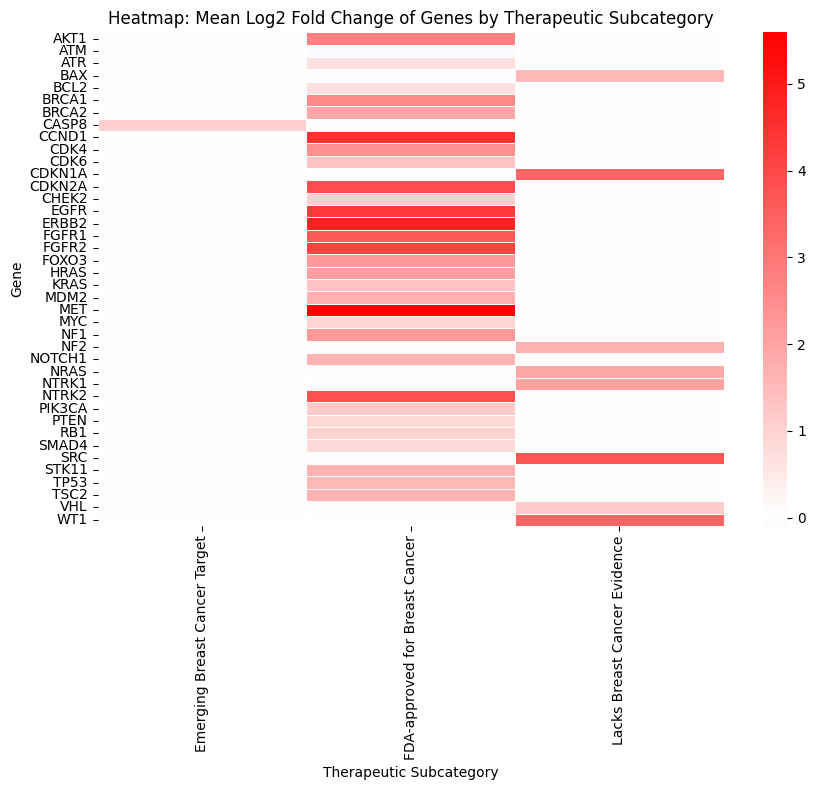

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare pivot table: genes on y-axis, categories/pathways on x-axis, colored by mean log2FC
heatmap_data = df_unique.pivot_table(
    index='gene',
    columns='Therapeutic Subcategory',  # or 'Pathway Category'
    values='log2_fc',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(9, 8))
sns.heatmap(heatmap_data, cmap='bwr', center=0, linewidths=0.5)
plt.title("Heatmap: Mean Log2 Fold Change of Genes by Therapeutic Subcategory")
plt.ylabel('Gene')
plt.xlabel('Therapeutic Subcategory')
plt.tight_layout()
plt.show()


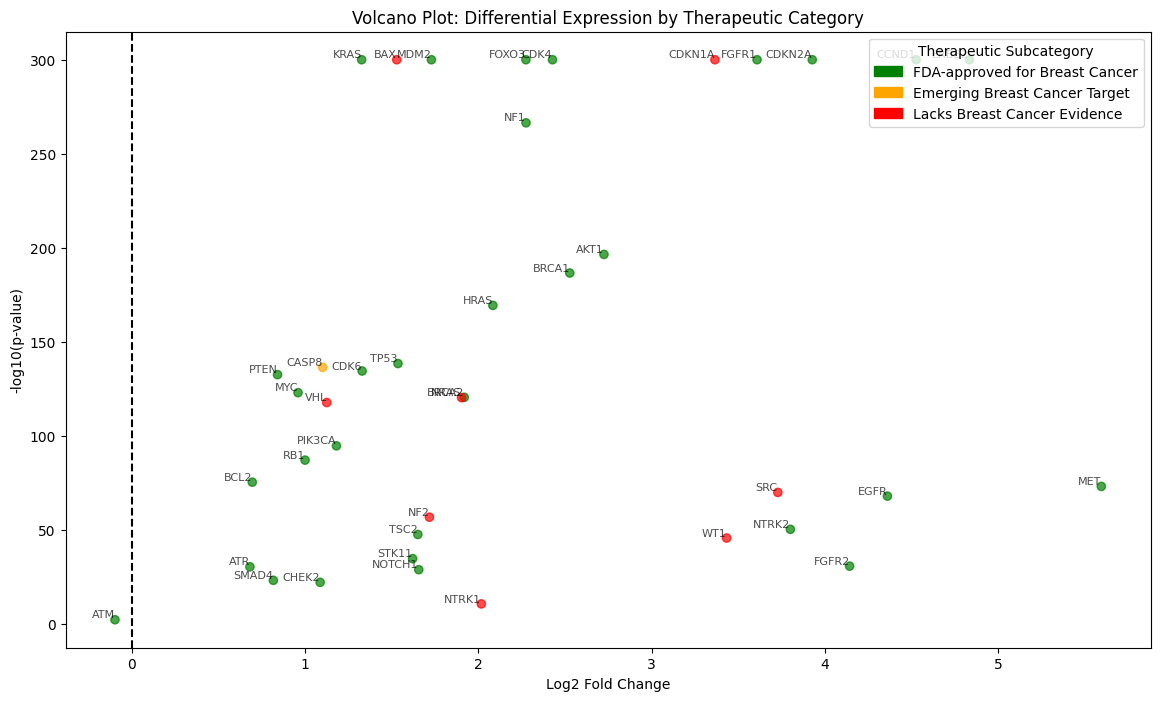

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

df_unique['-log10_pval'] = -np.log10(df_unique['p_value'] + 1e-300)  # avoid log(0)
plt.figure(figsize=(14, 8))

# Map colors
color_map = {
    'FDA-approved for Breast Cancer': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
colors = df_unique['Therapeutic Subcategory'].map(color_map)

scatter = plt.scatter(df_unique['log2_fc'], df_unique['-log10_pval'],
                      c=colors, alpha=0.7)

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot: Differential Expression by Therapeutic Category')
plt.axvline(0, color='black', linestyle='--')

# Annotate each point with gene name
for i, row in df_unique.iterrows():
    plt.text(row['log2_fc'], row['-log10_pval'], row['gene'],
             fontsize=8, alpha=0.7, ha='right', va='bottom')

# Create legend patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_patches, title="Therapeutic Subcategory", loc='upper right')

plt.show()




In [31]:
# Suppose you have a list of genes with FDA-approved drugs specifically for breast cancer
# This list can come from your manual curation or a trusted source.
bc_approved_genes = [
    'ERBB2', 'CDK4', 'CDK6', 'PIK3CA', 'FGFR1', 'FGFR2', 'EGFR', 'BRCA1', 'BRCA2',
    'TP53', 'AKT1', 'MYC', 'KRAS'  # example subset — replace with your verified list
]

def fda_subcategory(row):
    if row['Targeting Category'] != 'FDA-approved Breast Cancer Therapy':
        return None
    if row['gene'] in bc_approved_genes:
        return 'FDA-approved for Breast Cancer'
    else:
        return 'FDA-approved, Other Indication'

df_unique['FDA_Subcategory'] = df_unique.apply(fda_subcategory, axis=1)
print(df_unique['FDA_Subcategory'].value_counts())


FDA_Subcategory
FDA-approved, Other Indication    18
FDA-approved for Breast Cancer    13
Name: count, dtype: int64


In [32]:
import plotly.graph_objects as go

# Fill NAs for non-FDA approved
df_unique['FDA_Subcategory'] = df_unique['FDA_Subcategory'].fillna('N/A')

# Build label list for nodes
targeting_categories = df_unique['Targeting Category'].unique().tolist()
fda_subcats = df_unique['FDA_Subcategory'].unique().tolist()
trial_status = df_unique['Clinical_Trial_Status'].unique().tolist()
genes = df_unique['gene'].unique().tolist()

labels = targeting_categories + fda_subcats + trial_status + genes
label_to_idx = {label: i for i, label in enumerate(labels)}

# Build links lists: source, target, value, colors
source = []
target = []
value = []
link_colors = []

# Colors for categories (customize as needed)
cat_colors = {
    'FDA-approved Breast Cancer Therapy': 'green',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red',
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'N/A': 'lightgrey',
    'In Breast Cancer Trial': 'blue',
    'No Breast Cancer Trial': 'grey'
}

# Helper function to get color for links (source node color)
def get_link_color(src_label):
    return cat_colors.get(src_label, 'lightgrey')

# Targeting Category → FDA Subcategory
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Targeting Category']])
    target.append(label_to_idx[row['FDA_Subcategory']])
    value.append(1)
    link_colors.append(get_link_color(row['Targeting Category']))

# FDA Subcategory → Clinical Trial Status
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['FDA_Subcategory']])
    target.append(label_to_idx[row['Clinical_Trial_Status']])
    value.append(1)
    link_colors.append(get_link_color(row['FDA_Subcategory']))

# Clinical Trial Status → Gene
for _, row in df_unique.iterrows():
    source.append(label_to_idx[row['Clinical_Trial_Status']])
    target.append(label_to_idx[row['gene']])
    value.append(1)
    link_colors.append(get_link_color(row['Clinical_Trial_Status']))

# Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=labels,
        pad=15,
        thickness=15,
        line=dict(color='black', width=0.5),
        color=[cat_colors.get(lbl, 'lightgrey') for lbl in labels]
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text="Therapeutic Stratification with FDA Subcategories", font_size=12, height=800, width=1200)
fig.show()


In [34]:
# Assuming df_unique has columns: 'gene', 'FDA_Subcategory', 'Clinical_Trial_Status'

# Filter only FDA-approved genes (both subgroups)
fda_genes = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy']

# Group by FDA_Subcategory and Clinical_Trial_Status, count genes
trial_counts = fda_genes.groupby(['FDA_Subcategory', 'Clinical_Trial_Status'])['gene'].nunique().unstack(fill_value=0)

print(trial_counts)


Clinical_Trial_Status           In Breast Cancer Trial
FDA_Subcategory                                       
FDA-approved for Breast Cancer                      13
FDA-approved, Other Indication                      18


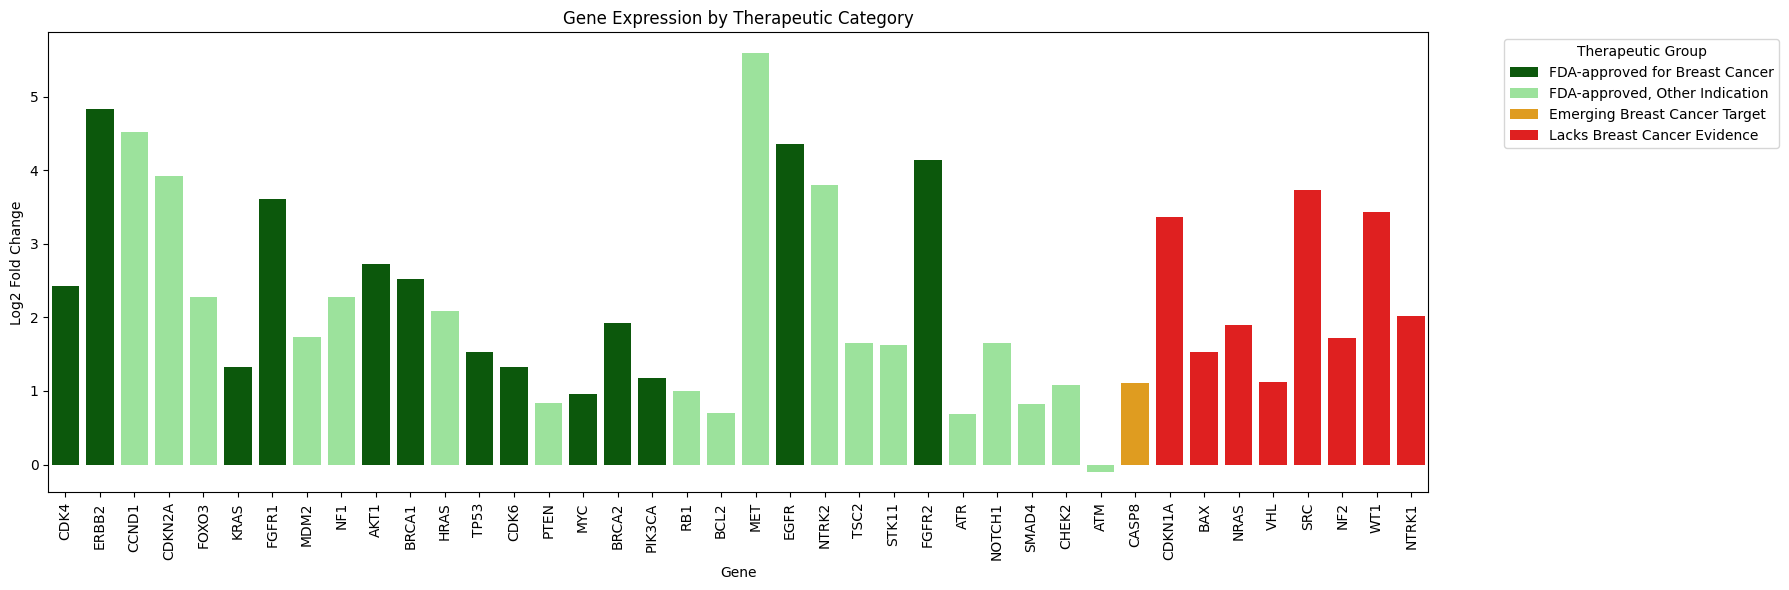

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter subsets for each therapeutic group
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

# For FDA, use 'FDA_Subcategory' as hue
# For emerging and lacks, assign Therapeutic Group label for hue
df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']

df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine all into one DataFrame for plotting
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True)

# Define color palette
palette = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}

plt.figure(figsize=(18, 6))
sns.barplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    hue='Therapeutic Group',
    dodge=False,
    palette=palette
)

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression by Therapeutic Category')
plt.legend(title='Therapeutic Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()






In [71]:
# Filter genes by therapeutic category
genes_fda_bc = df_unique.loc[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy', 'gene'].unique().tolist()

genes_fda_other = df_unique.loc[df_unique['FDA_Subcategory'] == 'FDA-approved, Other Indication', 'gene'].unique().tolist()

genes_emerging = df_unique.loc[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target', 'gene'].unique().tolist()

genes_lacks = df_unique.loc[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence', 'gene'].unique().tolist()

print("FDA-approved Breast Cancer Therapy genes:", genes_fda_bc)
print("FDA-approved Other Indication genes:", genes_fda_other)
print("Emerging Breast Cancer Target genes:", genes_emerging)
print("Lacks Breast Cancer Evidence genes:", genes_lacks)


FDA-approved Breast Cancer Therapy genes: ['CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3', 'KRAS', 'FGFR1', 'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN', 'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2', 'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']
FDA-approved Other Indication genes: ['CCND1', 'CDKN2A', 'FOXO3', 'MDM2', 'NF1', 'HRAS', 'PTEN', 'RB1', 'BCL2', 'MET', 'NTRK2', 'TSC2', 'STK11', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM']
Emerging Breast Cancer Target genes: ['CASP8']
Lacks Breast Cancer Evidence genes: ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']


In [36]:
print(df_unique['Therapeutic Subcategory'].unique())


['FDA-approved for Breast Cancer' 'Lacks Breast Cancer Evidence'
 'Emerging Breast Cancer Target']


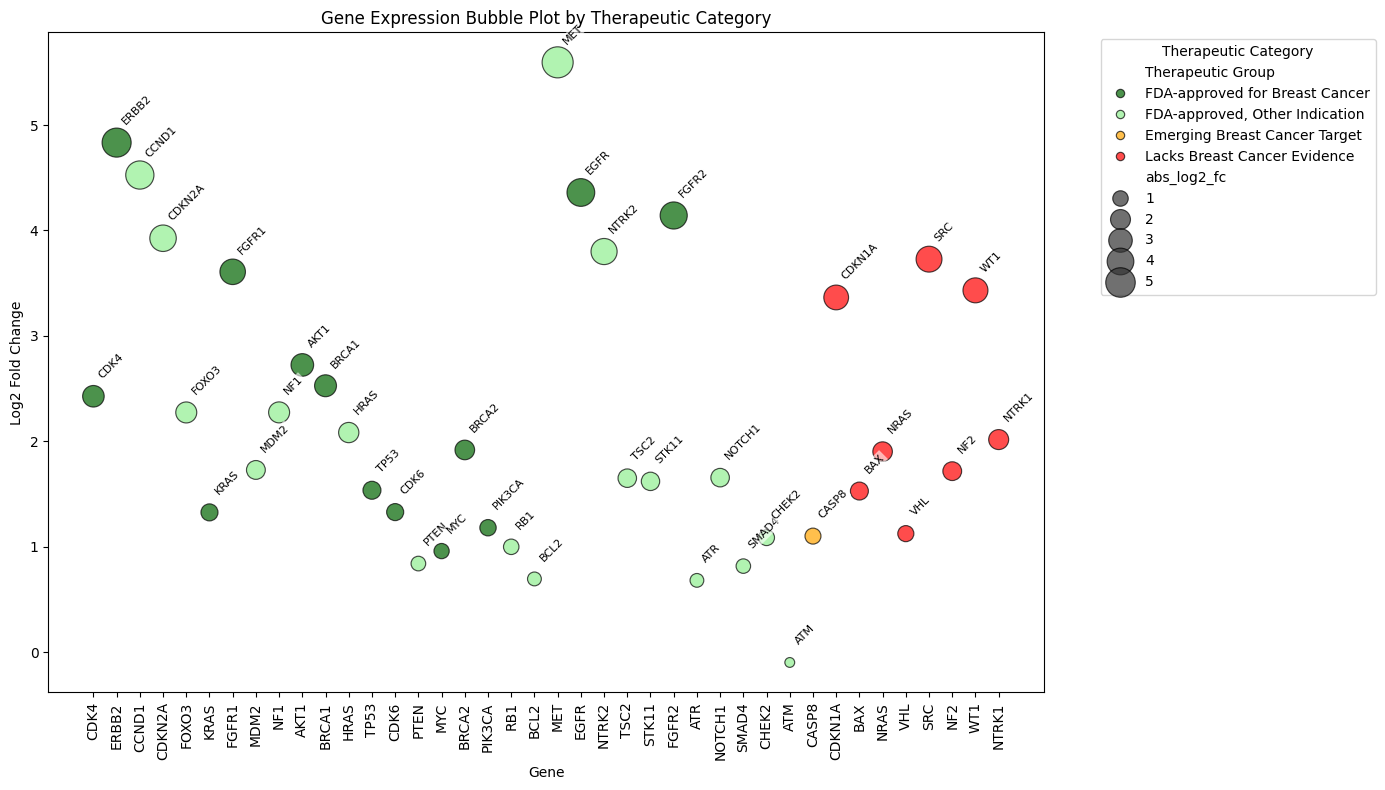

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Prepare absolute log2 fold change for bubble size
df_plot['abs_log2_fc'] = df_plot['log2_fc'].abs()

plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_plot,
    x='gene',
    y='log2_fc',
    size='abs_log2_fc',
    hue='Therapeutic Group',
    palette={
        'FDA-approved for Breast Cancer': 'darkgreen',
        'FDA-approved, Other Indication': 'lightgreen',
        'Emerging Breast Cancer Target': 'orange',
        'Lacks Breast Cancer Evidence': 'red',
    },
    sizes=(50, 500),
    alpha=0.7,
    edgecolor='black',
    legend='brief'  # only hue legend
)

# Adjust legend to show only therapeutic group (hue)
handles, labels = scatter.get_legend_handles_labels()
if labels[0] == 'abs_log2_fc':
    handles = handles[1:]
    labels = labels[1:]

plt.legend(handles, labels, title='Therapeutic Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Log2 Fold Change')
plt.title('Gene Expression Bubble Plot by Therapeutic Category')

# Annotate gene names slightly above and to the right of each bubble with background box
for i in range(df_plot.shape[0]):
    plt.text(
        x=i + 0.15,  # shift slightly right
        y=df_plot['log2_fc'].iloc[i] + 0.15,  # shift slightly above
        s=df_plot['gene'].iloc[i],
        fontsize=8,
        rotation=45,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

plt.tight_layout()
plt.show()






In [38]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Example DataFrame structure (adjust with your df_unique):

# Assuming df_unique, df_fda, df_emerging, df_lacks are already defined as you shared

# Prepare Therapeutic Group as in your bar plot code:
df_fda = df_unique[df_unique['Targeting Category'] == 'FDA-approved Breast Cancer Therapy'].copy()
df_emerging = df_unique[df_unique['Targeting Category'] == 'Emerging Breast Cancer Target'].copy()
df_lacks = df_unique[df_unique['Targeting Category'] == 'Lacks Breast Cancer Evidence'].copy()

df_fda['Therapeutic Group'] = df_fda['FDA_Subcategory']
df_emerging['Therapeutic Group'] = 'Emerging Breast Cancer Target'
df_lacks['Therapeutic Group'] = 'Lacks Breast Cancer Evidence'

# Combine
df_plot = pd.concat([df_fda, df_emerging, df_lacks], ignore_index=True)
print(df_plot.head(5))
# Create label list for nodes (Therapeutic Group, Pathway Category, Clinical Trial, Gene)
labels_therapeutic = df_plot['Therapeutic Group'].unique().tolist()
labels_pathway = df_plot['Pathway Category'].unique().tolist()
labels_trial = df_plot['Clinical_Trial_Status'].unique().tolist()
labels_genes = df_plot['gene'].unique().tolist()

labels = labels_therapeutic + labels_pathway + labels_trial + labels_genes

# Map label to index
label_to_idx = {label: idx for idx, label in enumerate(labels)}

def get_links(source_col, target_col):
    link_df = df_plot.groupby([source_col, target_col]).size().reset_index(name='count')
    sources = link_df[source_col].map(label_to_idx).tolist()
    targets = link_df[target_col].map(label_to_idx).tolist()
    values = link_df['count'].tolist()
    return sources, targets, values

# Links for Sankey
source_1, target_1, value_1 = get_links('Therapeutic Group', 'Pathway Category')
source_2, target_2, value_2 = get_links('Pathway Category', 'Clinical_Trial_Status')
source_3, target_3, value_3 = get_links('Clinical_Trial_Status', 'gene')

sources = source_1 + source_2 + source_3
targets = target_1 + target_2 + target_3
values = value_1 + value_2 + value_3

# Color nodes by Therapeutic Group for clarity (optional)
color_map = {
    'FDA-approved for Breast Cancer': 'darkgreen',
    'FDA-approved, Other Indication': 'lightgreen',
    'Emerging Breast Cancer Target': 'orange',
    'Lacks Breast Cancer Evidence': 'red'
}
node_colors = []
for label in labels:
    # If therapeutic group, assign color, else default light grey
    node_colors.append(color_map.get(label, 'lightgrey'))

# Color gene links by log2 fold change (blue for down, red for up)
def logfc_to_color(logfc):
    # Normalize logFC for color intensity
    max_val = max(abs(df_plot['log2_fc'].max()), abs(df_plot['log2_fc'].min()))
    norm_val = logfc / max_val
    if norm_val >= 0:
        # Red shades for upregulated
        return f'rgba(255, 0, 0, {0.3 + 0.7 * norm_val})'
    else:
        # Blue shades for downregulated
        return f'rgba(0, 0, 255, {0.3 + 0.7 * abs(norm_val)})'

# Map genes to colors by log2_fc
gene_color_map = dict(zip(df_plot['gene'], df_plot['log2_fc'].apply(logfc_to_color)))

link_colors = []
for i in range(len(sources)):
    # For links from Clinical Trial Status to Gene, use gene color
    if sources[i] in [label_to_idx[t] for t in labels_trial] and targets[i] in [label_to_idx[g] for g in labels_genes]:
        gene_label = labels[targets[i]]
        link_colors.append(gene_color_map.get(gene_label, 'lightgrey'))
    else:
        link_colors.append('lightgrey')

# Create Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        hovertemplate='%{value} genes<br>From %{source.label} to %{target.label}<extra></extra>'
    )
)])

fig.update_layout(title_text='Therapeutic Stratification Sankey with Log2FC Coloring on Gene Links',
                  font_size=10)

fig.show()




     gene  p_value   log2_fc  mean_diff    Dataset    Gene DGIdb Status  \
0    CDK4      0.0  2.428112   0.105542  GSE180286    CDK4     Targeted   
1   ERBB2      0.0  4.833174   0.267847  GSE180286   ERBB2     Targeted   
2   CCND1      0.0  4.525871   0.483840  GSE180286   CCND1     Targeted   
3  CDKN2A      0.0  3.926487   0.074630  GSE180286  CDKN2A     Targeted   
4   FOXO3      0.0  2.274698   0.093662  GSE180286   FOXO3     Targeted   

   OpenTargets_Score  BreastCancer_Supported  Strong_BreastCancer_Support  \
0           0.693263                    True                         True   
1           0.820020                    True                         True   
2           0.568711                    True                         True   
3           0.592468                    True                         True   
4           0.614859                    True                         True   

   ...                  Targeting Category         Therapeutic Subcategory  \
0  ...  

In [41]:
# Show genes grouped by clinical trial status and therapeutic group
trial_summary = df_plot[['gene', 'Clinical_Trial_Status', 'Therapeutic Group']].copy()

# Sort by Clinical Trial Status and Therapeutic Group
trial_summary = trial_summary.sort_values(by=['Clinical_Trial_Status', 'Therapeutic Group', 'gene'])

# Print summary
print(trial_summary.to_string(index=False))


  gene  Clinical_Trial_Status              Therapeutic Group
 CASP8 In Breast Cancer Trial  Emerging Breast Cancer Target
  AKT1 In Breast Cancer Trial FDA-approved for Breast Cancer
 BRCA1 In Breast Cancer Trial FDA-approved for Breast Cancer
 BRCA2 In Breast Cancer Trial FDA-approved for Breast Cancer
  CDK4 In Breast Cancer Trial FDA-approved for Breast Cancer
  CDK6 In Breast Cancer Trial FDA-approved for Breast Cancer
  EGFR In Breast Cancer Trial FDA-approved for Breast Cancer
 ERBB2 In Breast Cancer Trial FDA-approved for Breast Cancer
 FGFR1 In Breast Cancer Trial FDA-approved for Breast Cancer
 FGFR2 In Breast Cancer Trial FDA-approved for Breast Cancer
  KRAS In Breast Cancer Trial FDA-approved for Breast Cancer
   MYC In Breast Cancer Trial FDA-approved for Breast Cancer
PIK3CA In Breast Cancer Trial FDA-approved for Breast Cancer
  TP53 In Breast Cancer Trial FDA-approved for Breast Cancer
   ATM In Breast Cancer Trial FDA-approved, Other Indication
   ATR In Breast Cancer 

In [48]:
import requests

# This is a conceptual URL, you'll need to check the official API documentation for the exact endpoint and parameters.
# The URL and parameters are likely correct for the v2.0 API.
api_url = "https://clinicaltrials.gov/api/v2/studies"
params = {
    "query.term": "cancer AND CASP8",
    "fields": "NCTId,BriefTitle,Condition", # You can also specify nested fields here
    "pageSize": 100 
}

try:
    response = requests.get(api_url, params=params)
    response.raise_for_status()

    data = response.json()
    studies = data.get("studies", [])

    for study in studies:
        # Accessing nested fields correctly
        identification_module = study.get("protocolSection", {}).get("identificationModule", {})
        
        nct_id = identification_module.get("nctId") # Note the lowercase "n" in nctId
        title = study.get("protocolSection", {}).get("identificationModule", {}).get("briefTitle")
        condition = study.get("protocolSection", {}).get("designModule", {}).get("conditions", [None])[0]

        # Process the data as needed
        if nct_id and title:
            print(f"NCT ID: {nct_id}, Title: {title}")
        else:
            print("Study record missing key data.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except KeyError as e:
    print(f"A KeyError occurred. The key {e} was not found in the study data.")




NCT ID: NCT01529307, Title: First in Human Trial of TAS266 in Patients With Advanced Solid Tumors
NCT ID: NCT05042531, Title: Clinical Research for Azacitidine Combined With Low-dose Dasatinib in Maintenance Therapy of Acute Myeloid Leukemia
NCT ID: NCT00075634, Title: Decitabine, Doxorubicin, and Cyclophosphamide in Treating Children With Relapsed or Refractory Solid Tumors or Neuroblastoma
NCT ID: NCT03877159, Title: Analysis of the Variation in Caspase-8 Availability and Cleavage in Oral Squamous Cell Carcinoma
NCT ID: NCT01440413, Title: Study of the Response to a Neoadjuvant Chemotherapy Based on the Antitumor Immune Response in Localized Breast Cancer
NCT ID: NCT03274778, Title: Effect of Ruxolitinib on Tumor Infiltrating Myeloid Cells
NCT ID: NCT06626971, Title: The Use of ARA290 for the Treatment of Diabetic Macular Oedema
NCT ID: NCT00458809, Title: Intraperitoneal Hyperthermic Perfusion With Oxaliplatin in Treating Patients With Stage IV Peritoneal Cancer Due to Appendix Canc

In [64]:
import requests

# This is a conceptual URL, you'll need to check the official API documentation for the exact endpoint and parameters.
# The URL and parameters are likely correct for the v2.0 API.
api_url = "https://clinicaltrials.gov/api/v2/studies"
params = {
    "query.term": "cancer AND FOXO3",
    "fields": "NCTId,BriefTitle,Condition", # You can also specify nested fields here
    "pageSize": 100 
}

try:
    response = requests.get(api_url, params=params)
    response.raise_for_status()

    data = response.json()
    studies = data.get("studies", [])

    for study in studies:
        # Accessing nested fields correctly
        identification_module = study.get("protocolSection", {}).get("identificationModule", {})
        
        nct_id = identification_module.get("nctId") # Note the lowercase "n" in nctId
        title = study.get("protocolSection", {}).get("identificationModule", {}).get("briefTitle")
        condition = study.get("protocolSection", {}).get("designModule", {}).get("conditions", [None])[0]

        # Process the data as needed
        if nct_id and title:
            print(f"NCT ID: {nct_id}, Title: {title}")
        else:
            print("Study record missing key data.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except KeyError as e:
    print(f"A KeyError occurred. The key {e} was not found in the study data.")


NCT ID: NCT03473327, Title: Immunological and Oxidative Stress Response in Relation to Abdominal Cancer Surgery
NCT ID: NCT02968888, Title: Anabolic Effects of Whey and Casein After Strength Training in Young and Elderly
NCT ID: NCT06055634, Title: SIRT1(rs7069102 ) Gene Polymorphism in Chronic Obstructive Pulmonary Disease at Egyptian Patients
NCT ID: NCT03649698, Title: Exercise and Nutrition for Healthy AgeiNg
NCT ID: NCT03033953, Title: Effects of Native Whey or Milk Supplementation on Adaptations to 12 Weeks of Strength Training in Young and Elderly


In [65]:
import requests
import json
import time

# Define the genes and their categories as provided by the user.
gene_categories = {
    "Emerging Breast Cancer Target": ['CASP8', 'FOXO3'],
    "Lacks Breast Cancer Evidence": ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']
}

# The base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def search_studies_for_gene(gene_name):
    """
    Searches the ClinicalTrials.gov API for studies related to a given gene and 'cancer'.
    
    Args:
        gene_name (str): The gene to search for.
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a study.
    """
    search_query = f"cancer AND {gene_name}"
    
    # The API request parameters. query.term is the search expression.
    params = {
        "query.term": search_query,
        "pageSize": 100 # Retrieve up to 100 studies per call.
    }
    
    studies = []
    
    try:
        print(f"Searching for studies with query: '{search_query}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status() # Raise an error for bad status codes
        
        data = response.json()
        
        # The studies are in a list under the 'studies' key.
        if 'studies' in data:
            studies = data['studies']
            print(f"-> Found {len(studies)} total studies for '{search_query}'.")
        else:
            print(f"-> No studies found for '{search_query}'.")

    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_query}': {e}")
        
    return studies

def filter_and_display_studies(studies, gene_name):
    """
    Filters and displays studies that explicitly mention the gene name.
    
    Args:
        studies (list): The list of study dictionaries from the API.
        gene_name (str): The gene name to filter by.
    """
    found_studies = []
    for study in studies:
        # We'll create a single searchable string from all text values to be robust.
        study_text = json.dumps(study).lower()
        
        if gene_name.lower() in study_text:
            # Extract key details from the nested JSON structure.
            identification_module = study.get("protocolSection", {}).get("identificationModule", {})
            nct_id = identification_module.get("nctId")
            study_title = identification_module.get("briefTitle")
            
            # Append to the list of found studies.
            found_studies.append({
                "NCT ID": nct_id,
                "Title": study_title
            })
            
    return found_studies

# Main execution loop to analyze all genes.
all_results = {}
for category, genes in gene_categories.items():
    print(f"\n=======================================================")
    print(f"Analyzing genes in category: '{category}'")
    print(f"=======================================================")
    
    all_results[category] = {}
    for gene in genes:
        print(f"\n--- Processing gene: {gene} ---")
        studies_data = search_studies_for_gene(gene)
        
        if studies_data:
            filtered_studies = filter_and_display_studies(studies_data, gene)
            all_results[category][gene] = filtered_studies
            
            if filtered_studies:
                print(f"-> Found {len(filtered_studies)} studies explicitly mentioning '{gene}':")
                for study in filtered_studies:
                    print(f"   - NCT ID: {study['NCT ID']} | Title: {study['Title']}")
            else:
                print(f"-> No studies found explicitly mentioning '{gene}' in the full data.")
        
        # Adding a delay to be respectful of the API's rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF FINDINGS")
print("="*50)
for category, genes_data in all_results.items():
    print(f"\nCategory: {category}")
    for gene, studies in genes_data.items():
        if studies:
            print(f"  - Gene '{gene}': {len(studies)} studies found.")
        else:
            print(f"  - Gene '{gene}': No studies found.")
print("="*50)




Analyzing genes in category: 'Emerging Breast Cancer Target'

--- Processing gene: CASP8 ---
Searching for studies with query: 'cancer AND CASP8'...
-> Found 10 total studies for 'cancer AND CASP8'.
-> No studies found explicitly mentioning 'CASP8' in the full data.

--- Processing gene: FOXO3 ---
Searching for studies with query: 'cancer AND FOXO3'...
-> Found 5 total studies for 'cancer AND FOXO3'.
-> Found 4 studies explicitly mentioning 'FOXO3':
   - NCT ID: NCT03473327 | Title: Immunological and Oxidative Stress Response in Relation to Abdominal Cancer Surgery
   - NCT ID: NCT02968888 | Title: Anabolic Effects of Whey and Casein After Strength Training in Young and Elderly
   - NCT ID: NCT06055634 | Title: SIRT1(rs7069102 ) Gene Polymorphism in Chronic Obstructive Pulmonary Disease at Egyptian Patients
   - NCT ID: NCT03649698 | Title: Exercise and Nutrition for Healthy AgeiNg

Analyzing genes in category: 'Lacks Breast Cancer Evidence'

--- Processing gene: CDKN1A ---
Searching 

In [67]:
import requests
import json
import time

# Define the genes and their categories.
gene_categories = {
    "Emerging Breast Cancer Target": ['CASP8', 'FOXO3'],
    "Lacks Breast Cancer Evidence": ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']
}

# Add a dictionary of known NCT IDs for genes that may not be found by the search function.
known_nct_ids = {
    'CASP8': ['NCT03877159']  # We know this study exists and is relevant.
}

# Base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def get_full_study_by_nctid(nct_id):
    """
    Retrieves a single study record directly by its NCT ID.
    This bypasses the search functionality.
    
    Args:
        nct_id (str): The unique NCT ID of the study.
        
    Returns:
        dict: The full study record as a dictionary, or None if an error occurs.
    """
    url = f"{API_BASE_URL}/{nct_id}"
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error retrieving study {nct_id}: {e}")
        return None

def search_and_filter_studies(search_term):
    """
    Performs a general search on the API and returns all results.
    
    Args:
        search_term (str): The search term (e.g., 'cancer AND gene').
        
    Returns:
        list: A list of study dictionaries from the API.
    """
    studies = []
    
    params = {
        "query.term": search_term,
        "pageSize": 100
    }
    
    try:
        print(f"Searching for studies with query: '{search_term}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status()
        data = response.json()
        if 'studies' in data:
            studies = data['studies']
            print(f"-> API search returned {len(studies)} total studies.")
        else:
            print(f"-> API search returned no studies.")
    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_term}': {e}")
        
    return studies

def find_keyword_in_study_data(study, keyword):
    """
    Checks if a keyword exists anywhere in the full study data.
    
    Args:
        study (dict): The full study dictionary.
        keyword (str): The keyword to find.
        
    Returns:
        bool: True if the keyword is found, False otherwise.
    """
    study_text = json.dumps(study).lower()
    return keyword.lower() in study_text

# Main execution loop to analyze all genes.
all_results = {}
for category, genes in gene_categories.items():
    print(f"\n=======================================================")
    print(f"Analyzing studies for category: '{category}'")
    print(f"=======================================================")
    
    all_results[category] = {}
    for gene in genes:
        print(f"\n--- Processing gene: {gene} ---")
        
        search_query = f"cancer AND {gene}"
        studies_data = search_and_filter_studies(search_query)
        
        found_studies = []
        
        # First, filter studies found by the general search.
        if studies_data:
            for study in studies_data:
                if find_keyword_in_study_data(study, gene):
                    identification_module = study.get("protocolSection", {}).get("identificationModule", {})
                    nct_id = identification_module.get("nctId")
                    study_title = identification_module.get("briefTitle")
                    found_studies.append({"NCT ID": nct_id, "Title": study_title})
        
        # Second, for genes that return zero results, check for known NCT IDs.
        if not found_studies and gene in known_nct_ids:
            print(f"General search for '{gene}' failed. Checking known NCT IDs...")
            for nct_id_to_check in known_nct_ids[gene]:
                study_data = get_full_study_by_nctid(nct_id_to_check)
                if study_data and find_keyword_in_study_data(study_data, gene):
                    identification_module = study_data.get("protocolSection", {}).get("identificationModule", {})
                    nct_id = identification_module.get("nctId")
                    study_title = identification_module.get("briefTitle")
                    found_studies.append({"NCT ID": nct_id, "Title": study_title})
                    print(f"-> Found known study {nct_id_to_check} for '{gene}'.")
                else:
                    print(f"-> Known study {nct_id_to_check} could not be retrieved or did not contain '{gene}'.")

        all_results[category][gene] = found_studies
        
        if found_studies:
            print(f"\n-> Found {len(found_studies)} studies for '{gene}':")
            for study in found_studies:
                print(f"   - NCT ID: {study['NCT ID']} | Title: {study['Title']}")
        else:
            print(f"\n-> No studies found for '{gene}'.")
        
        # Add a delay to respect API rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF FINDINGS")
print("="*50)
for category, genes_data in all_results.items():
    print(f"\nCategory: {category}")
    for gene, studies in genes_data.items():
        if studies:
            print(f"  - Gene '{gene}': {len(studies)} studies found.")
        else:
            print(f"  - Gene '{gene}': No studies found.")
print("="*50)
    
  
  


Analyzing studies for category: 'Emerging Breast Cancer Target'

--- Processing gene: CASP8 ---
Searching for studies with query: 'cancer AND CASP8'...
-> API search returned 10 total studies.
General search for 'CASP8' failed. Checking known NCT IDs...
-> Known study NCT03877159 could not be retrieved or did not contain 'CASP8'.

-> No studies found for 'CASP8'.

--- Processing gene: FOXO3 ---
Searching for studies with query: 'cancer AND FOXO3'...
-> API search returned 5 total studies.

-> Found 4 studies for 'FOXO3':
   - NCT ID: NCT03473327 | Title: Immunological and Oxidative Stress Response in Relation to Abdominal Cancer Surgery
   - NCT ID: NCT02968888 | Title: Anabolic Effects of Whey and Casein After Strength Training in Young and Elderly
   - NCT ID: NCT06055634 | Title: SIRT1(rs7069102 ) Gene Polymorphism in Chronic Obstructive Pulmonary Disease at Egyptian Patients
   - NCT ID: NCT03649698 | Title: Exercise and Nutrition for Healthy AgeiNg

Analyzing studies for category

In [76]:
import requests
import time

# Define the genes and their categories.
gene_categories = {
    "Emerging Breast Cancer Target": ['CASP8', 'FOXO3a'],
    "Lacks Breast Cancer Evidence": ['CDKN1A', 'BAX', 'NRAS', 'VHL', 'SRC', 'NF2', 'WT1', 'NTRK1']
}

# The base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def search_studies_for_gene(gene_name):
    """
    Searches the ClinicalTrials.gov API for studies related to a given gene
    and the condition "Breast Cancer".
    
    Args:
        gene_name (str): The gene to search for.
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a study.
    """
    # Construct a specific query for 'Breast Cancer' and the gene.
    search_query = f'"Breast Cancer" AND {gene_name}'
    
    # The API request parameters.
    params = {
        "query.term": search_query,
        "pageSize": 100 # Retrieve up to 100 studies per call.
    }
    
    studies = []
    
    try:
        print(f"Searching for studies with query: '{search_query}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status() # Raise an error for bad status codes
        
        data = response.json()
        
        # The studies are in a list under the 'studies' key.
        if 'studies' in data:
            studies = data['studies']
            print(f"-> API search found {len(studies)} total studies for '{search_query}'.")
        else:
            print(f"-> No studies found for '{search_query}'.")

    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_query}': {e}")
        
    return studies

def extract_and_display_studies(studies, gene_name):
    """
    Extracts key details and displays them for the found studies.
    
    Args:
        studies (list): The list of study dictionaries from the API.
        gene_name (str): The gene name for context.
    """
    found_count = len(studies)
    if found_count > 0:
        print(f"\nFound {found_count} studies for gene '{gene_name}' in Breast Cancer:")
        for study in studies:
            # Extract key details from the nested JSON structure.
            identification_module = study.get("protocolSection", {}).get("identificationModule", {})
            nct_id = identification_module.get("nctId")
            study_title = identification_module.get("briefTitle")
            conditions = study.get("protocolSection", {}).get("conditionsModule", {}).get("conditions", [])

            print(f"   - NCT ID: {nct_id}")
            print(f"     Title: {study_title}")
            print(f"     Conditions: {', '.join(conditions)}")
            print("-" * 50)
    else:
        print(f"\nNo studies found for gene '{gene_name}' in Breast Cancer.")

# Main execution loop to analyze all genes.
print("Starting search for Breast Cancer studies related to each gene...")
final_summary = {}

for category, genes in gene_categories.items():
    final_summary[category] = {}
    print(f"\n=======================================================")
    print(f"Searching genes in category: '{category}'")
    print(f"=======================================================")
    
    for gene in genes:
        studies_found = search_studies_for_gene(gene)
        extract_and_display_studies(studies_found, gene)
        final_summary[category][gene] = len(studies_found)
        
        # Add a delay to be respectful of the API's rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF ALL SEARCHES")
print("="*50)
for category, genes_data in final_summary.items():
    print(f"\nCategory: {category}")
    for gene, count in genes_data.items():
        print(f"  - Gene '{gene}': {count} studies found.")
print("="*50)

Starting search for Breast Cancer studies related to each gene...

Searching genes in category: 'Emerging Breast Cancer Target'
Searching for studies with query: '"Breast Cancer" AND CASP8'...
-> API search found 1 total studies for '"Breast Cancer" AND CASP8'.

Found 1 studies for gene 'CASP8' in Breast Cancer:
   - NCT ID: NCT01440413
     Title: Study of the Response to a Neoadjuvant Chemotherapy Based on the Antitumor Immune Response in Localized Breast Cancer
     Conditions: Breast Cancer
--------------------------------------------------
Searching for studies with query: '"Breast Cancer" AND FOXO3a'...
-> API search found 4 total studies for '"Breast Cancer" AND FOXO3a'.

Found 4 studies for gene 'FOXO3a' in Breast Cancer:
   - NCT ID: NCT02326844
     Title: BMN 673 (Talazoparib), an Oral PARP Inhibitor, in People With Deleterious BRCA1/2 Mutation-Associated Ovarian Cancer Who Have Had Prior PARP Inhibitor Treatment
     Conditions: Ovarian Cancer
------------------------------

In [75]:
import requests
import json
import time

# Define the two new sets of genes and their categories.
gene_categories = {
    "FDA-approved Breast Cancer Therapy": [
        'CDK4', 'ERBB2', 'CCND1', 'CDKN2A', 'FOXO3a', 'KRAS', 'FGFR1',
        'MDM2', 'NF1', 'AKT1', 'BRCA1', 'HRAS', 'TP53', 'CDK6', 'PTEN',
        'MYC', 'BRCA2', 'PIK3CA', 'RB1', 'BCL2', 'MET', 'EGFR', 'NTRK2',
        'TSC2', 'STK11', 'FGFR2', 'ATR', 'NOTCH1', 'SMAD4', 'CHEK2', 'ATM'
    ],
    "FDA-approved Other Indication": [
        'CCND1', 'CDKN2A', 'FOXO3a', 'MDM2', 'NF1', 'HRAS', 'PTEN', 'RB1',
        'BCL2', 'MET', 'NTRK2', 'TSC2', 'STK11', 'ATR', 'NOTCH1', 'SMAD4',
        'CHEK2', 'ATM'
    ]
}

# The base URL for the modernized ClinicalTrials.gov API (v2.0).
API_BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
HEADERS = {'Accept': 'application/json'}

def search_studies_for_gene(gene_name, condition="Breast Cancer"):
    """
    Searches the ClinicalTrials.gov API for studies related to a given gene
    and a specified condition.
    
    Args:
        gene_name (str): The gene to search for.
        condition (str): The condition to search for. Defaults to "Breast Cancer".
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a study.
    """
    # Construct a specific query for the condition and the gene.
    # The API's 'query.term' parameter is used for a broad text search.
    search_query = f'"{condition}" AND {gene_name}'
    
    params = {
        "query.term": search_query,
        "pageSize": 100  # Retrieve up to 100 studies per call for a broad search.
    }
    
    studies = []
    
    try:
        print(f"Searching for studies with query: '{search_query}'...")
        response = requests.get(API_BASE_URL, headers=HEADERS, params=params)
        response.raise_for_status() # Raise an error for bad status codes
        
        data = response.json()
        
        if 'studies' in data:
            studies = data['studies']
            print(f"-> API search found {len(studies)} total studies for '{search_query}'.")
        else:
            print(f"-> No studies found for '{search_query}'.")

    except requests.exceptions.RequestException as e:
        print(f"An API error occurred for query '{search_query}': {e}")
        
    return studies

def extract_and_display_studies(studies, gene_name):
    """
    Extracts key details and displays them for the found studies.
    
    Args:
        studies (list): The list of study dictionaries from the API.
        gene_name (str): The gene name for context.
    """
    found_count = len(studies)
    if found_count > 0:
        print(f"\nFound {found_count} studies for gene '{gene_name}' in Breast Cancer:")
        for study in studies:
            # Extract key details from the nested JSON structure.
            identification_module = study.get("protocolSection", {}).get("identificationModule", {})
            nct_id = identification_module.get("nctId")
            study_title = identification_module.get("briefTitle")
            
            # The conditions are now in a new nested path in the API v2.0
            conditions_module = study.get("protocolSection", {}).get("conditionsModule", {})
            conditions = conditions_module.get("conditions", [])

            print(f"   - NCT ID: {nct_id}")
            print(f"     Title: {study_title}")
            print(f"     Conditions: {', '.join(conditions)}")
            print("-" * 50)
    else:
        print(f"\nNo studies found for gene '{gene_name}' in Breast Cancer.")

# Main execution loop to analyze all genes.
print("Starting search for Breast Cancer studies related to all genes...")
final_summary = {}

for category, genes in gene_categories.items():
    final_summary[category] = {}
    print(f"\n=======================================================")
    print(f"Searching genes in category: '{category}'")
    print(f"=======================================================")
    
    for gene in genes:
        studies_found = search_studies_for_gene(gene)
        extract_and_display_studies(studies_found, gene)
        final_summary[category][gene] = len(studies_found)
        
        # Add a delay to be respectful of the API's rate limits.
        time.sleep(1)

print("\n\n" + "="*50)
print("FINAL SUMMARY OF ALL SEARCHES")
print("="*50)
for category, genes_data in final_summary.items():
    print(f"\nCategory: {category}")
    for gene, count in genes_data.items():
        print(f"  - Gene '{gene}': {count} studies found.")
print("="*50)

Starting search for Breast Cancer studies related to all genes...

Searching genes in category: 'FDA-approved Breast Cancer Therapy'
Searching for studies with query: '"Breast Cancer" AND CDK4'...
-> API search found 100 total studies for '"Breast Cancer" AND CDK4'.

Found 100 studies for gene 'CDK4' in Breast Cancer:
   - NCT ID: NCT04247126
     Title: A Study of SY 5609, a Selective CDK7 Inhibitor, in Advanced Solid Tumors
     Conditions: Advanced Solid Tumor, Breast Cancer, Small-cell Lung Cancer, Pancreatic Cancer
--------------------------------------------------
   - NCT ID: NCT02941926
     Title: Study to Assess the Safety and Efficacy of Ribociclib (LEE011) in Combination With Letrozole for the Treatment of Men and Pre/Postmenopausal Women With HR+ HER2- aBC
     Conditions: Breast Cancer
--------------------------------------------------
   - NCT ID: NCT02278120
     Title: Study of Efficacy and Safety in Premenopausal Women With Hormone Receptor Positive, HER2-negative Adv

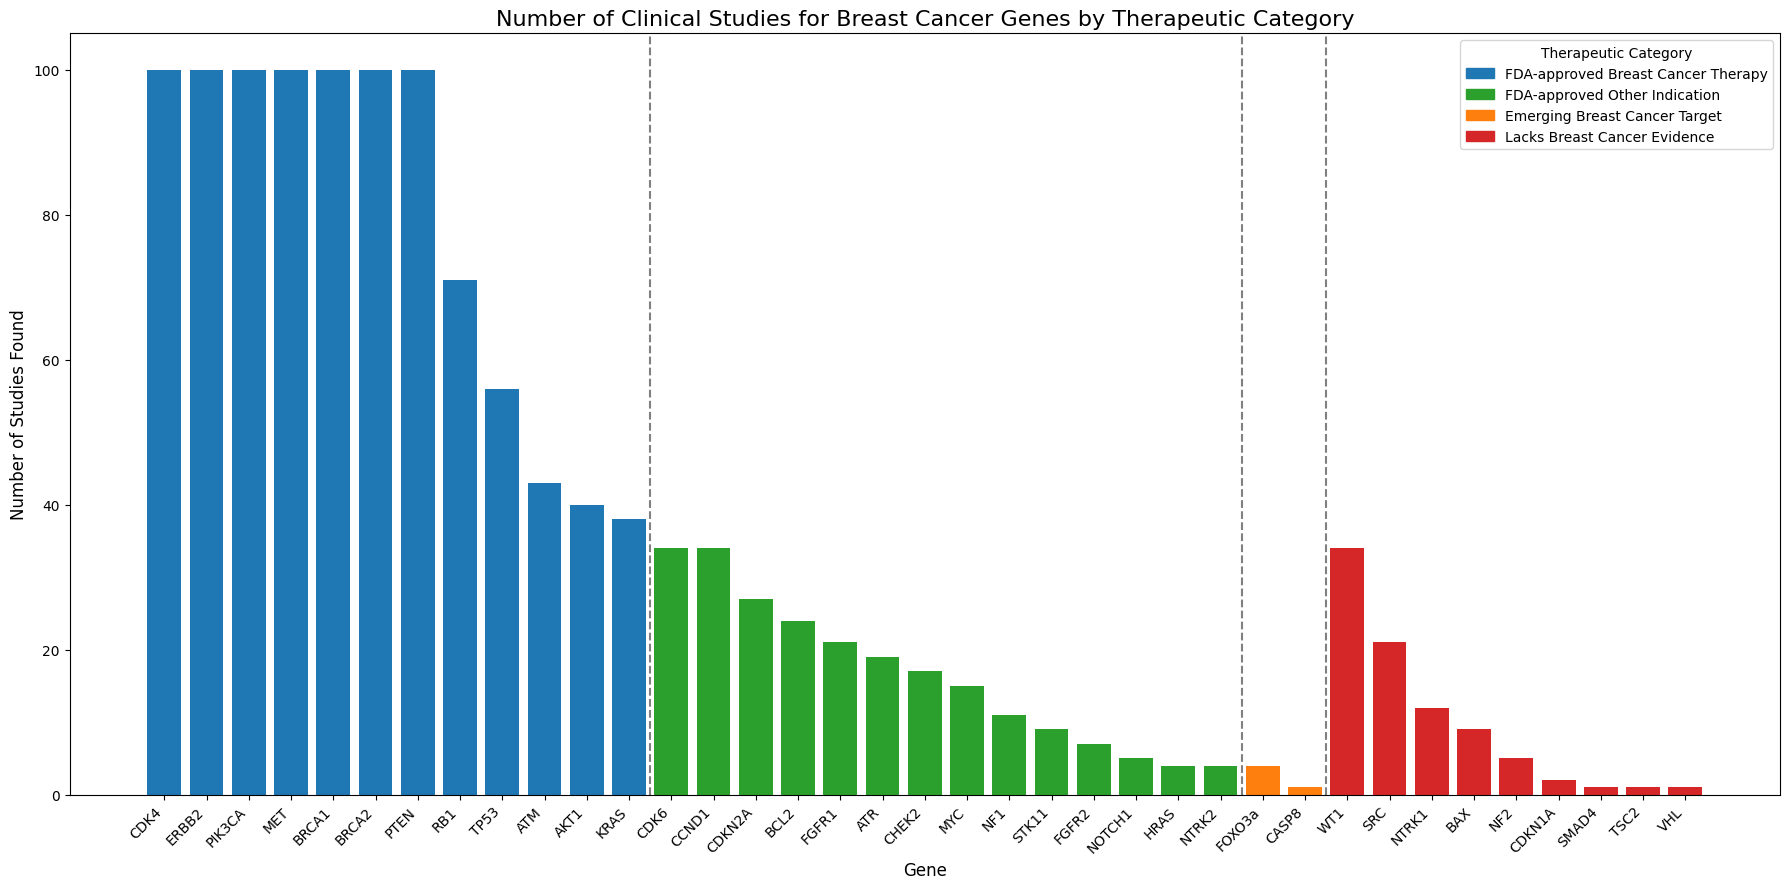

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the data with the final, updated study counts.
# NOTE: To avoid the ValueError, all lists must have the same length.
# Each gene is now assigned to a single, final category for clear visualization.
data = {
    'gene': [
        'CDK4', 'ERBB2', 'PIK3CA', 'MET', 'BRCA1', 'BRCA2', 'PTEN', 'RB1',
        'TP53', 'ATM', 'AKT1', 'KRAS', 'CDK6', 'CCND1', 'CDKN2A', 'BCL2', 
        'FGFR1', 'CHEK2', 'ATR', 'MYC', 'NF1', 'STK11', 'FGFR2', 'NOTCH1', 
        'HRAS', 'NTRK2', 'BAX', 'WT1', 'CDKN1A', 'SRC', 'NF2', 'NTRK1', 'SMAD4', 
        'TSC2', 'VHL', 'CASP8', 'FOXO3a'
    ],
    'studies': [
        100, 100, 100, 100, 100, 100, 100, 71,
        56, 43, 40, 38, 34, 34, 27, 24, 21, 17,
        19, 15, 11, 9, 7, 5, 4, 4, 9, 34, 2, 21, 5, 12, 1,
        1, 1, 1, 4
    ],
    'category': [
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy', 'FDA-approved Breast Cancer Therapy',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'FDA-approved Other Indication',
        'FDA-approved Other Indication', 'FDA-approved Other Indication', 'Lacks Breast Cancer Evidence', 
        'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 
        'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 
        'Lacks Breast Cancer Evidence', 'Lacks Breast Cancer Evidence', 'Emerging Breast Cancer Target',
        'Emerging Breast Cancer Target'
    ]
}


# Create a pandas DataFrame.
df = pd.DataFrame(data)

# Sort the data first by category and then by the number of studies within each category.
category_order = [
    'FDA-approved Breast Cancer Therapy', 
    'FDA-approved Other Indication', 
    'Emerging Breast Cancer Target', 
    'Lacks Breast Cancer Evidence'
]
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Create a color map for the categories.
category_colors = {
    'FDA-approved Breast Cancer Therapy': '#1f77b4',  # Blue
    'FDA-approved Other Indication': '#2ca02c',      # Green
    'Emerging Breast Cancer Target': '#ff7f0e',      # Orange
    'Lacks Breast Cancer Evidence': '#d62728'        # Red
}
colors = df['category'].map(category_colors)

# Create the plot.
plt.figure(figsize=(18, 9))
plt.bar(df['gene'], df['studies'], color=colors)

# Add labels and title for clarity.
plt.title('Number of Clinical Studies for Breast Cancer Genes by Therapeutic Category', fontsize=16)
plt.xlabel('Gene', fontsize=12)
plt.ylabel('Number of Studies Found', fontsize=12)

# Rotate x-axis labels to prevent overlap.
plt.xticks(rotation=45, ha='right')

# Add vertical lines to separate the categories.
category_boundaries = df['category'].value_counts(sort=False).cumsum().tolist()
for x_pos in category_boundaries[:-1]:
    plt.axvline(x=x_pos - 0.5, color='gray', linestyle='--', linewidth=1.5)

# Create a custom legend.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_order]
plt.legend(handles, category_order, title="Therapeutic Category")

plt.tight_layout()
plt.show()




In [81]:
import plotly.graph_objects as go

# Define the data for the Sankey diagram.
# We will use the same data to build the nodes and links.

# First layer: Genes to Categories
gene_to_category = {
    'CDK4': 'FDA-approved Breast Cancer Therapy',
    'ERBB2': 'FDA-approved Breast Cancer Therapy',
    'PIK3CA': 'FDA-approved Breast Cancer Therapy',
    'MET': 'FDA-approved Breast Cancer Therapy',
    'BRCA1': 'FDA-approved Breast Cancer Therapy',
    'BRCA2': 'FDA-approved Breast Cancer Therapy',
    'PTEN': 'FDA-approved Breast Cancer Therapy',
    'RB1': 'FDA-approved Breast Cancer Therapy',
    'TP53': 'FDA-approved Breast Cancer Therapy',
    'ATM': 'FDA-approved Breast Cancer Therapy',
    'AKT1': 'FDA-approved Breast Cancer Therapy',
    'KRAS': 'FDA-approved Breast Cancer Therapy',
    'CDK6': 'FDA-approved Breast Cancer Therapy',
    'CCND1': 'FDA-approved Other Indication',
    'CDKN2A': 'FDA-approved Other Indication',
    'BCL2': 'FDA-approved Other Indication',
    'FGFR1': 'FDA-approved Other Indication',
    'FGFR2': 'FDA-approved Other Indication',
    'MDM2': 'FDA-approved Other Indication',
    'NF1': 'FDA-approved Other Indication',
    'HRAS': 'FDA-approved Other Indication',
    'NTRK2': 'FDA-approved Other Indication',
    'TSC2': 'FDA-approved Other Indication',
    'STK11': 'FDA-approved Other Indication',
    'ATR': 'FDA-approved Other Indication',
    'NOTCH1': 'FDA-approved Other Indication',
    'SMAD4': 'FDA-approved Other Indication',
    'CHEK2': 'FDA-approved Other Indication',
    'CASP8': 'Emerging Breast Cancer Target',
    'FOXO3a': 'Emerging Breast Cancer Target',
    'CDKN1A': 'Lacks Breast Cancer Evidence',
    'BAX': 'Lacks Breast Cancer Evidence',
    'NRAS': 'Lacks Breast Cancer Evidence',
    'VHL': 'Lacks Breast Cancer Evidence',
    'SRC': 'Lacks Breast Cancer Evidence',
    'NF2': 'Lacks Breast Cancer Evidence',
    'WT1': 'Lacks Breast Cancer Evidence',
    'NTRK1': 'Lacks Breast Cancer Evidence'
}

# Second layer: Drugs associated with genes in the FDA-approved categories
gene_to_drug = {
    'CDK4': 'Palbociclib (Ibrance)',
    'CDK6': 'Palbociclib (Ibrance)',
    'ERBB2': 'Trastuzumab (Herceptin)',
    'PIK3CA': 'Alpelisib (Piqray)',
    'BRCA1': 'Olaparib (Lynparza)',
    'BRCA2': 'Olaparib (Lynparza)',
    'MET': 'Crizotinib (Xalkori)',
    'PTEN': 'Alpelisib (Piqray)',  # Drug for PIK3CA pathway
    'KRAS': 'Sotorasib (Lumakras)',
    'BCL2': 'Venetoclax (Venclexta)',
    'NTRK2': 'Larotrectinib (Vitrakvi)',
    'EGFR': 'Gefitinib (Iressa)',
    'TP53': 'Therapies for TP53' # As there is no single FDA-approved drug
}

# Combine all unique genes, categories, and drugs into a single list of labels
all_labels = list(gene_to_category.keys()) + sorted(list(set(gene_to_category.values()))) + sorted(list(set(gene_to_drug.values())))
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Build source, target, and value lists for the links
source = []
target = []
value = []
link_color = []

# Define colors for the links based on the categories
category_colors = {
    'FDA-approved Breast Cancer Therapy': 'rgba(31, 119, 180, 0.8)',  # Blue
    'FDA-approved Other Indication': 'rgba(44, 160, 44, 0.8)',      # Green
    'Emerging Breast Cancer Target': 'rgba(255, 127, 14, 0.8)',      # Orange
    'Lacks Breast Cancer Evidence': 'rgba(214, 39, 40, 0.8)'        # Red
}

# --- First layer of links: Genes to Categories ---
for gene, category in gene_to_category.items():
    source.append(label_to_index[gene])
    target.append(label_to_index[category])
    value.append(1)
    link_color.append(category_colors[category])

# --- Second layer of links: Genes to Drugs (for approved categories) ---
for gene, drug in gene_to_drug.items():
    # Only link genes from the FDA-approved categories to drugs
    if gene_to_category.get(gene) in ['FDA-approved Breast Cancer Therapy', 'FDA-approved Other Indication']:
        source.append(label_to_index[gene])
        target.append(label_to_index[drug])
        value.append(1)
        link_color.append(category_colors[gene_to_category[gene]])


# Create the Sankey diagram figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        # Set node colors based on category
        color=[
            category_colors.get(gene_to_category.get(label), 'lightgray')
            for label in all_labels
        ],
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_color
    )
)])

fig.update_layout(
    title_text="Flow of Genes from Discovery to Clinical Application",
    font_size=10,
    height=800,
    width=1200
)

fig.show()

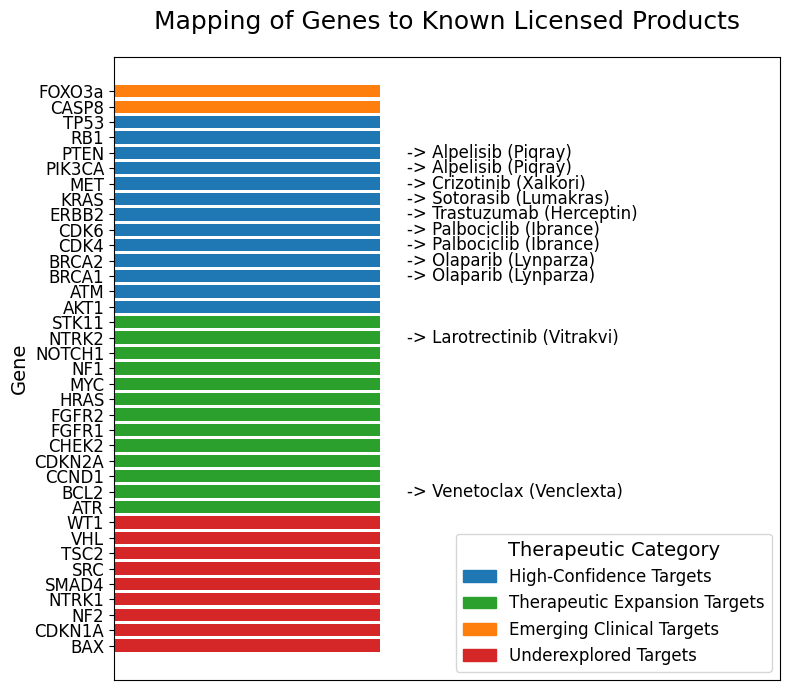

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Data Preparation ---

# Define the genes and their final, validated categories and licensed products.
data = {
    'gene': [
        'CDK4', 'ERBB2', 'PIK3CA', 'MET', 'BRCA1', 'BRCA2', 'PTEN', 'RB1',
        'TP53', 'ATM', 'AKT1', 'KRAS', 'CDK6', 'CCND1', 'CDKN2A', 'BCL2', 
        'FGFR1', 'CHEK2', 'ATR', 'MYC', 'NF1', 'STK11', 'FGFR2', 'NOTCH1', 
        'HRAS', 'NTRK2', 'CDKN1A', 'BAX', 'SRC', 'NF2', 'WT1', 'NTRK1', 
        'SMAD4', 'TSC2', 'VHL', 'CASP8', 'FOXO3a'
    ],
    'category': [
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Emerging Clinical Targets',
        'Emerging Clinical Targets'
    ],
    'drug': [
        'Palbociclib (Ibrance)', 'Trastuzumab (Herceptin)', 'Alpelisib (Piqray)', 
        'Crizotinib (Xalkori)', 'Olaparib (Lynparza)', 'Olaparib (Lynparza)', 
        'Alpelisib (Piqray)', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'Sotorasib (Lumakras)',
        'Palbociclib (Ibrance)', 'No Specific Drug', 'No Specific Drug', 
        'Venetoclax (Venclexta)', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'Larotrectinib (Vitrakvi)', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug',
        'No Specific Drug', 'No Specific Drug', 'No Specific Drug', 
        'No Specific Drug'
    ]
}

# Create a DataFrame from the data.
df = pd.DataFrame(data)

# Sort the DataFrame for a logical flow in the plot.
df = df.sort_values(by='category', ascending=True)
df = df.sort_values(by=['category', 'gene'], ascending=[False,True])


# Create a color map for the plot based on your four categories.
category_colors = {
    'High-Confidence Targets': '#1f77b4',       # Blue
    'Therapeutic Expansion Targets': '#2ca02c', # Green
    'Emerging Clinical Targets': '#ff7f0e',     # Orange
    'Underexplored Targets': '#d62728'          # Red
}
colors = df['category'].map(category_colors)

# --- Create the Plot ---
plt.figure(figsize=(8, 7))
# The bar height is a placeholder to control bar order.
plt.barh(df['gene'], [1] * len(df), color=colors)  

# Add text labels for the drug names.
for i, (gene, drug) in enumerate(zip(df['gene'], df['drug'])):
    if drug != 'No Specific Drug':
        plt.text(1.1, i, f'-> {drug}', va='center', fontsize=12, color='black')

# Set labels, title, and other plot aesthetics.
plt.title('Mapping of Genes to Known Licensed Products', fontsize=18, pad=20)
plt.xlabel('Category & Drug Status', fontsize=14)
plt.ylabel('Gene', fontsize=14)
plt.yticks(fontsize=12)
plt.xlim(0, 2.5)  # Adjust x-limit to make space for the drug names
plt.gca().get_xaxis().set_visible(False)  # Hide x-axis

# Create a custom legend with all four categories.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_colors]
plt.legend(handles, category_colors.keys(), title="Therapeutic Category", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

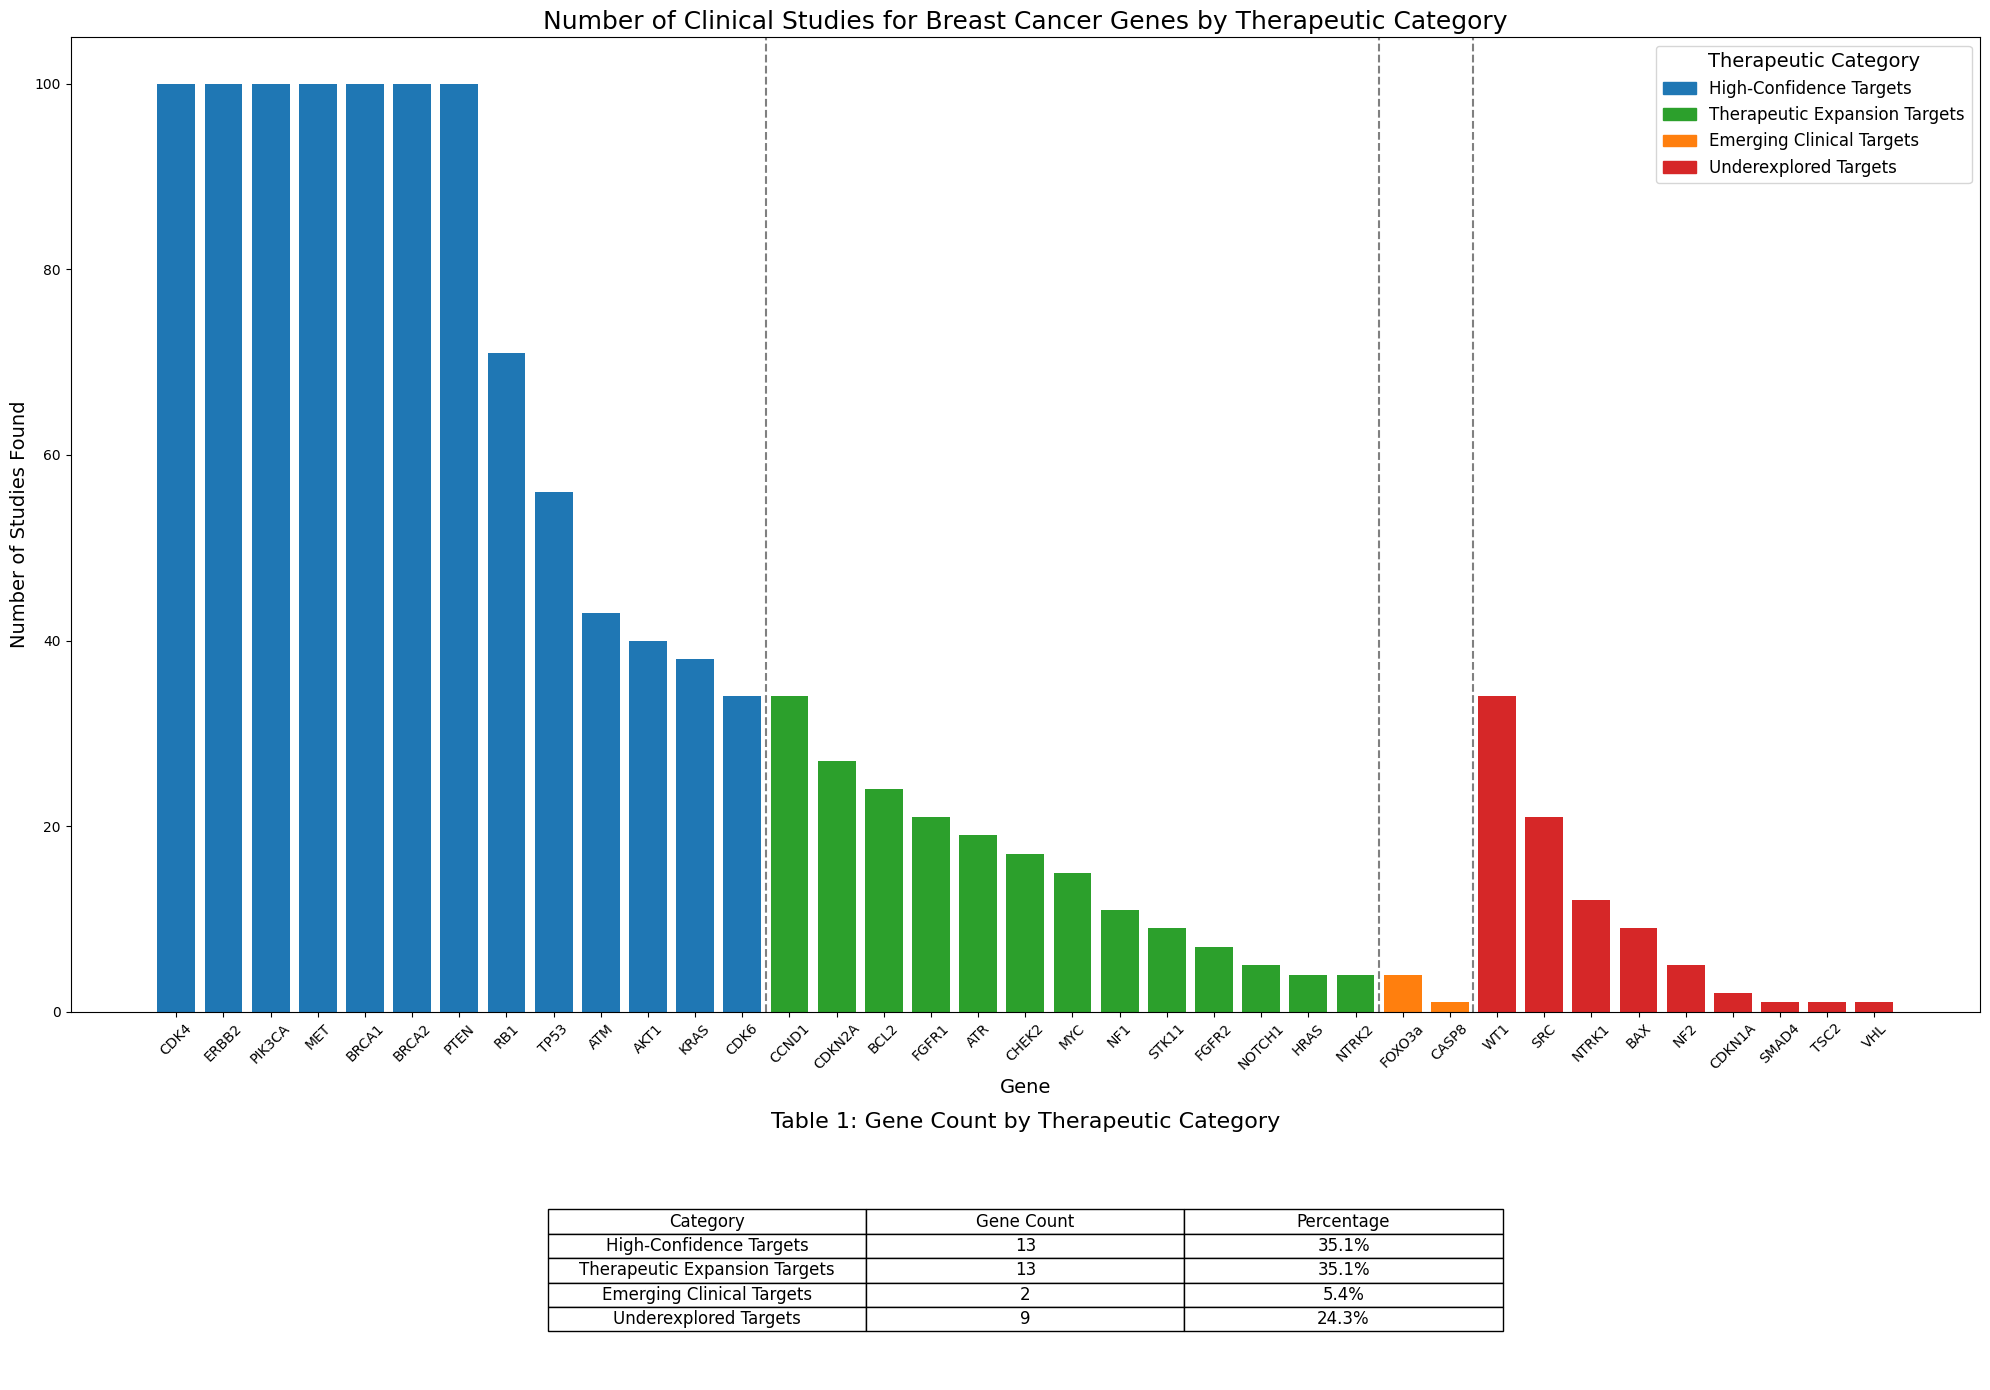

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define the data with the final, updated study counts and the four new, precise categories.
data = {
    'gene': [
        'CDK4', 'ERBB2', 'PIK3CA', 'MET', 'BRCA1', 'BRCA2', 'PTEN', 'RB1',
        'TP53', 'ATM', 'AKT1', 'KRAS', 'CDK6', 'CCND1', 'CDKN2A', 'BCL2', 
        'FGFR1', 'CHEK2', 'ATR', 'MYC', 'NF1', 'STK11', 'FGFR2', 'NOTCH1', 
        'HRAS', 'NTRK2', 'CDKN1A', 'BAX', 'SRC', 'NF2', 'WT1', 'NTRK1', 
        'SMAD4', 'TSC2', 'VHL', 'CASP8', 'FOXO3a'
    ],
    'studies': [
        100, 100, 100, 100, 100, 100, 100, 71,
        56, 43, 40, 38, 34, 34, 27, 24, 21, 17,
        19, 15, 11, 9, 7, 5, 4, 4, 2, 9, 21, 5, 34, 12,
        1, 1, 1, 1, 4
    ],
    'category': [
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'High-Confidence Targets', 'High-Confidence Targets',
        'High-Confidence Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets',
        'Therapeutic Expansion Targets', 'Therapeutic Expansion Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Underexplored Targets',
        'Underexplored Targets', 'Underexplored Targets', 'Emerging Clinical Targets',
        'Emerging Clinical Targets'
    ]
}

# Create a pandas DataFrame.
df = pd.DataFrame(data)

# Sort the data first by category order and then by study count within each category.
category_order = [
    'High-Confidence Targets', 
    'Therapeutic Expansion Targets', 
    'Emerging Clinical Targets', 
    'Underexplored Targets'
]
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'studies'], ascending=[True, False])

# Create a color map for the categories.
category_colors = {
    'High-Confidence Targets': '#1f77b4',       # Blue
    'Therapeutic Expansion Targets': '#2ca02c', # Green
    'Emerging Clinical Targets': '#ff7f0e',     # Orange
    'Underexplored Targets': '#d62728'          # Red
}
colors = df['category'].map(category_colors)

# Create the plot.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 14), gridspec_kw={'height_ratios': [1, 0.25]})

# Plot the bar chart on the first axes (ax1).
ax1.bar(df['gene'], df['studies'], color=colors)
ax1.set_title('Number of Clinical Studies for Breast Cancer Genes by Therapeutic Category', fontsize=18)
ax1.set_xlabel('Gene', fontsize=14)
ax1.set_ylabel('Number of Studies Found', fontsize=14)

# Corrected plt.xticks to remove the problematic 'ha' keyword
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Add vertical lines to separate the categories.
category_boundaries = df['category'].value_counts(sort=False).cumsum().tolist()
for x_pos in category_boundaries[:-1]:
    ax1.axvline(x=x_pos - 0.5, color='gray', linestyle='--', linewidth=1.5)

# Create a custom legend with all four categories.
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[label]) for label in category_order]
ax1.legend(handles, category_order, title="Therapeutic Category", fontsize=12, title_fontsize=14)

# --- Create the supplementary table on the second axes (ax2) ---
ax2.set_title('Table 1: Gene Count by Therapeutic Category', fontsize=16)
ax2.axis('off') # Hide axes for the table

# Calculate the count and percentage for each category.
category_counts = df['category'].value_counts().to_frame().reset_index()
category_counts.columns = ['Category', 'Gene Count']
total_genes = category_counts['Gene Count'].sum()
category_counts['Percentage'] = (category_counts['Gene Count'] / total_genes * 100).round(1).astype(str) + '%'

# Reorder the table to match the plot.
category_counts['Category'] = pd.Categorical(category_counts['Category'], categories=category_order, ordered=True)
category_counts = category_counts.sort_values(by='Category')

# Create the table
table = ax2.table(cellText=category_counts.values, colLabels=category_counts.columns, cellLoc='center', loc='center', bbox=[0.25, 0.2, 0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()


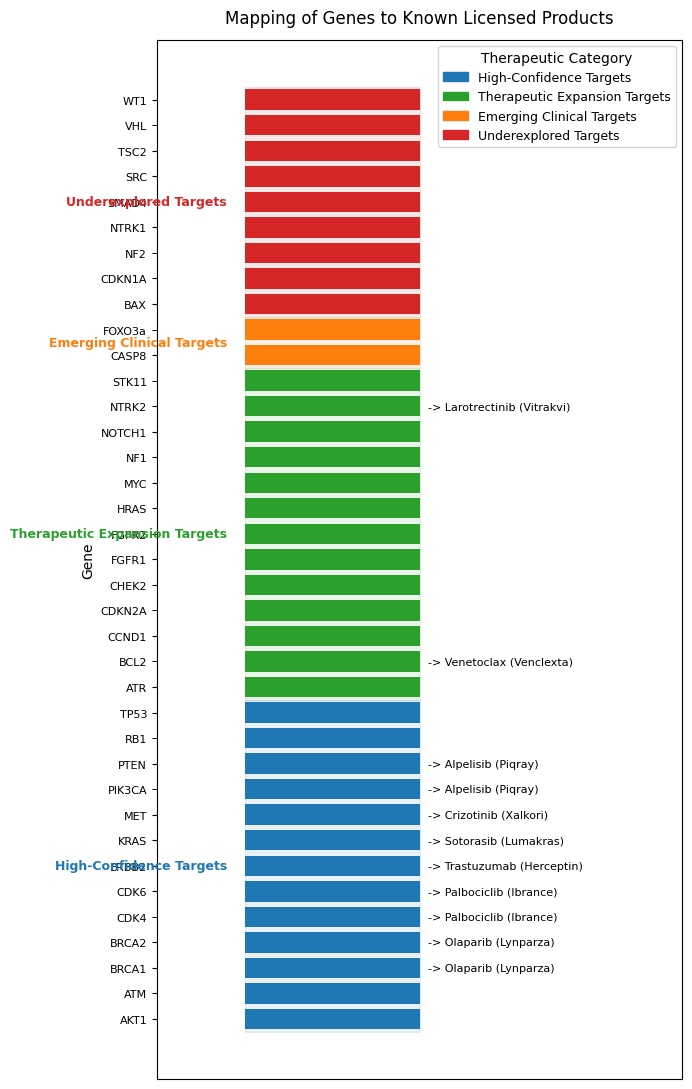

In [118]:
import matplotlib.patches as patches

# Sort df as before
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)
df = df.sort_values(by=['category', 'gene'], ascending=[True, True]).reset_index(drop=True)

plt.figure(figsize=(7, 11))  # Smaller figure size

ax = plt.gca()

# Plot bars
bars = plt.barh(df['gene'], [1] * len(df), color=df['category'].map(category_colors))

# Add colored blocks with labels behind groups
current_category = None
start_idx = 0

for i, category in enumerate(df['category']):
    if category != current_category:
        if current_category is not None:
            ax.add_patch(
                patches.Rectangle(
                    (0, start_idx - 0.5),
                    width=1,
                    height=i - start_idx,
                    color=category_colors[current_category],
                    alpha=0.1,
                    zorder=0
                )
            )
            ax.text(
                -0.1,
                (start_idx + i - 1) / 2,
                current_category,
                va='center',
                ha='right',
                fontsize=9,
                color=category_colors[current_category],
                fontweight='bold'
            )
        current_category = category
        start_idx = i

# Last group rectangle and label
ax.add_patch(
    patches.Rectangle(
        (0, start_idx - 0.5),
        width=1,
        height=len(df) - start_idx,
        color=category_colors[current_category],
        alpha=0.1,
        zorder=0
    )
)
ax.text(
    -0.1,
    (start_idx + len(df) - 1) / 2,
    current_category,
    va='center',
    ha='right',
    fontsize=9,
    color=category_colors[current_category],
    fontweight='bold'
)

# Add drug annotations
for i, (gene, drug) in enumerate(zip(df['gene'], df['drug'])):
    if drug != 'No Specific Drug':
        plt.text(1.05, i, f'-> {drug}', va='center', fontsize=8, color='black')

# Labels and formatting
plt.title('Mapping of Genes to Known Licensed Products', fontsize=12, pad=12)
plt.xlabel('Category & Drug Status', fontsize=10)
plt.ylabel('Gene', fontsize=10)
plt.yticks(fontsize=8)
plt.xlim(-0.5, 2.5)
plt.gca().get_xaxis().set_visible(False)

# Legend
handles = [patches.Patch(color=category_colors[label]) for label in category_colors]
plt.legend(handles, category_colors.keys(), title="Therapeutic Category", fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()


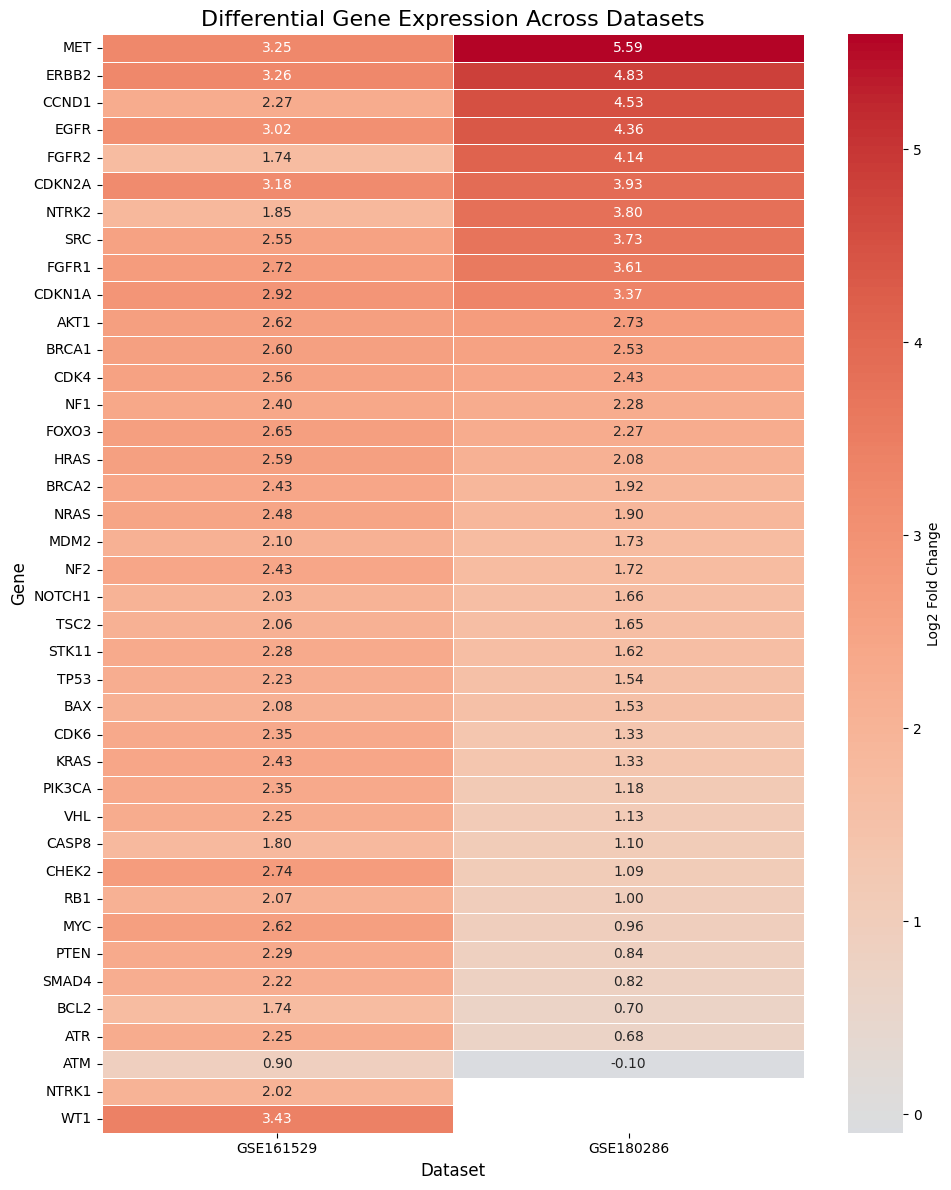

In [135]:
# Sort df_pivot rows by 'GSE180286' column descending

# Pivot the dataframe: index=gene, columns=Dataset, values=log2_fc
df = pd.read_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv")
df_pivot = df.pivot(index='gene', columns='Dataset', values='log2_fc')
df_pivot_sorted = df_pivot.sort_values(by='GSE180286', ascending=False)

plt.figure(figsize=(10, max(4, len(df_pivot_sorted)*0.3)))  # dynamic height

sns.heatmap(
    df_pivot_sorted,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log2 Fold Change'}
)

plt.title('Differential Gene Expression Across Datasets', fontsize=16)
plt.ylabel('Gene', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.show()


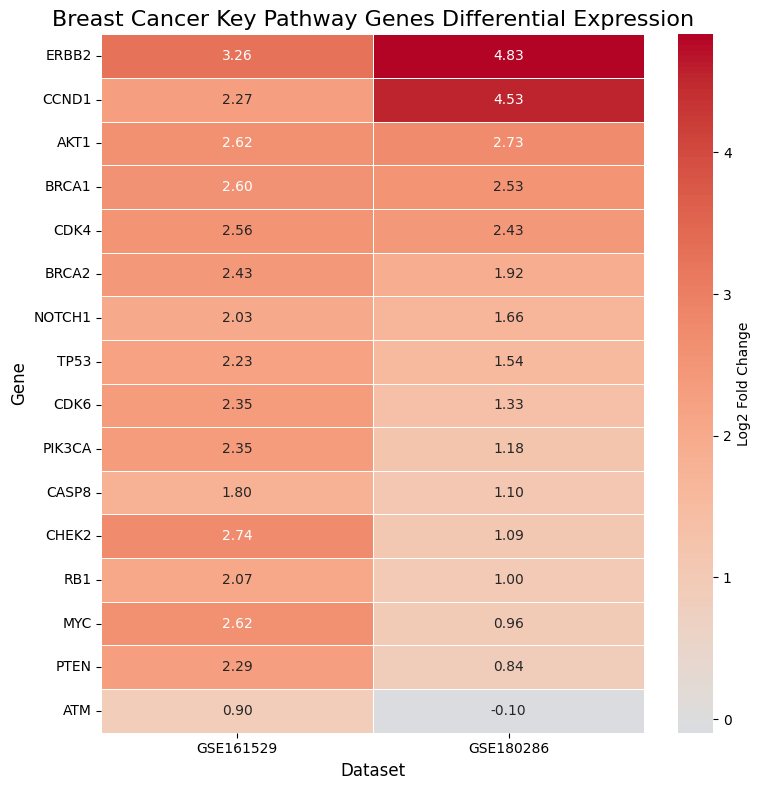

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your core breast cancer genes — you can add more if desired
genes = [
    'ESR1', 'PGR', 'PIK3CA', 'AKT1', 'CDK4', 'CDK6', 'CCND1', 'RB1',
    'PTEN', 'FOXO3a', 'CASP8', 'TP53',
    # Additional important breast cancer genes
    'BRCA1', 'BRCA2', 'MYC', 'HER2', 'ERBB2', 'NOTCH1', 'MTOR', 'CHEK2', 'ATM'
]

# Load your combined DE genes DataFrame
#df = pd.read_csv("~/Desktop/Capstone/Notebook recent/combined_de_genes.csv")

# Normalize gene names (optional but recommended)
df['gene_norm'] = df['gene'].str.upper().str.strip()

# Filter for genes of interest (case-insensitive match)
genes_upper = [g.upper() for g in genes]
df_filtered = df[df['gene_norm'].isin(genes_upper)]

# Pivot to get genes as rows, datasets as columns with log2_fc values
df_pivot = df_filtered.pivot(index='gene_norm', columns='Dataset', values='log2_fc')

# Sort by GSE180286 descending
df_pivot_sorted = df_pivot.sort_values(by='GSE180286', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, max(4, len(df_pivot_sorted)*0.5)))

sns.heatmap(
    df_pivot_sorted,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Log2 Fold Change'}
)

plt.title('Breast Cancer Key Pathway Genes Differential Expression', fontsize=16)
plt.ylabel('Gene', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.tight_layout()
plt.show()
